# Step 0: Import data files


In [0]:
import platform
import multiprocessing
import psutil
import time
import datetime as dt

print("Python version:", platform.python_version())
print("Processor:", platform.processor())
print("CPU cores:", multiprocessing.cpu_count())
print("Memory:", str(round(psutil.virtual_memory().total / (1024**3), 2)) + " GB")

# Start timing
start_time = time.time()
start_dt = dt.datetime.now()
print("Run started at:", start_dt.strftime("%Y-%m-%d %H:%M:%S"))



Python version: 3.12.3
Processor: aarch64
CPU cores: 4
Memory: 15.28 GB
Run started at: 2025-12-05 23:25:44


In [0]:
spark_df = spark.table("workspace.default.cs_training")
df_train = spark_df.toPandas()

spark_df2 = spark.table("workspace.default.cs_test")
df_test = spark_df2.toPandas()


In [0]:
import pandas as pd
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.766127,45,2,0.802982,9120,13,0,6,0,2
1,0.0,0.957151,40,0,0.121876,2600,4,0,0,0,1
2,0.0,0.658180,38,1,0.085113,3042,2,1,0,0,0
3,0.0,0.233810,30,0,0.036050,3300,5,0,0,0,0
4,0.0,0.907239,49,1,0.024926,63588,7,0,1,0,0


## Step 1: Understand & clean data

| Variable Name                               | Description                                                                                                 | Type        |
|---------------------------------------------|-------------------------------------------------------------------------------------------------------------|-------------|
| SeriousDlqin2yrs                            | Person experienced 90 days past due delinquency or worse, default target variable                                                    | Y/N         |
| RevolvingUtilizationOfUnsecuredLines        | Total balance on credit cards & personal lines of credit divided by credit limits                          | percentage  |
| age                                         | Age of borrower in years                                                                                    | integer     |
| NumberOfTime30-59DaysPastDueNotWorse        | Times borrower was 30–59 days past due but not worse in last 2 years                                       | integer     |
| DebtRatio                                   | Monthly debt payments / monthly gross income                                                                | percentage  |
| MonthlyIncome                               | Monthly income                                                                                              | real        |
| NumberOfOpenCreditLinesAndLoans             | Number of open loans & lines of credit                                                                     | integer     |
| NumberOfTimes90DaysLate                     | Times borrower was 90+ days past due                                                                        | integer     |
| NumberRealEstateLoansOrLines                | Number of mortgage & real estate loans including home-equity lines                                         | integer     |
| NumberOfTime60-89DaysPastDueNotWorse        | Times borrower was 60–89 days past due but not worse in last 2 years                                       | integer     |
| NumberOfDependents                          | Number of dependents excluding borrower                                                                     | integer     |


In [0]:
import numpy as np
df = df.replace("NA", np.nan)
df.info()
# Check total missing values per column
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401503 entries, 0 to 401502
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      300000 non-null  float64
 1   RevolvingUtilizationOfUnsecuredLines  401503 non-null  float64
 2   age                                   401503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  401503 non-null  int64  
 4   DebtRatio                             401503 non-null  float64
 5   MonthlyIncome                         321938 non-null  object 
 6   NumberOfOpenCreditLinesAndLoans       401503 non-null  int64  
 7   NumberOfTimes90DaysLate               401503 non-null  int64  
 8   NumberRealEstateLoansOrLines          401503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  401503 non-null  int64  
 10  NumberOfDependents                    391029 non-null  object 
dtype

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            79565
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                       10474
dtype: int64

The records with the target variable missing should be excluded.  
We need to fix three data types (target variable, and the two objective variables).  
After excluding missing target values, visualize the missing values of other variables to check.

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 401502
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      300000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  300000 non-null  float64
 2   age                                   300000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  300000 non-null  int64  
 4   DebtRatio                             300000 non-null  float64
 5   MonthlyIncome                         240538 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       300000 non-null  int64  
 7   NumberOfTimes90DaysLate               300000 non-null  int64  
 8   NumberRealEstateLoansOrLines          300000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  300000 non-null  int64  
 10  NumberOfDependents                    292152 non-null  float64
dtypes: fl

<Axes: >

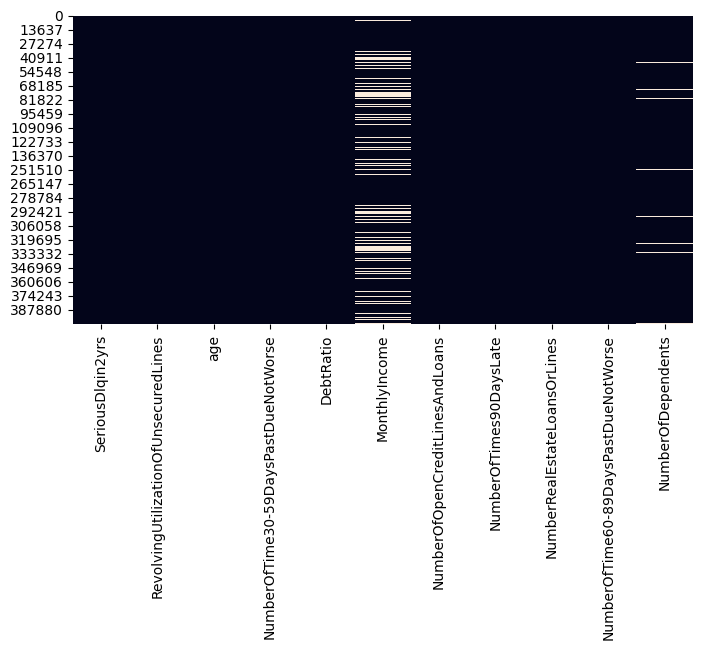

In [0]:
df = df.dropna(subset=["SeriousDlqin2yrs"])
df["MonthlyIncome"] = pd.to_numeric(df["MonthlyIncome"], errors="coerce")
df["NumberOfDependents"] = pd.to_numeric(df["NumberOfDependents"], errors="coerce")
df["SeriousDlqin2yrs"] = df["SeriousDlqin2yrs"].astype(int)
df.info()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.heatmap(df.isna(), cbar=False)


Nearly 20% of the monthlyincome varibale values are missing, the normal method of filling with median is considered but not enough, we can try to fill the missing values with median, and at the same time create a indicator of "monthly income missing" to capture this information (might be a valuable information).  
For the number of dependence missing values, we used the same method as the monthlyincome variable.  
We didn't consider PCA filling here, one important reason is that with 20% missing monthlyincome values, using pca may distort the data.   

In [0]:
# Add missing indicators
df["MonthlyIncome_missing"] = df["MonthlyIncome"].isna().astype(int)
df["NumberOfDependents_missing"] = df["NumberOfDependents"].isna().astype(int)

# Median impute
df["MonthlyIncome"].fillna(df["MonthlyIncome"].median(), inplace=True)
df["NumberOfDependents"].fillna(df["NumberOfDependents"].median(), inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 401502
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      300000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  300000 non-null  float64
 2   age                                   300000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  300000 non-null  int64  
 4   DebtRatio                             300000 non-null  float64
 5   MonthlyIncome                         300000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       300000 non-null  int64  
 7   NumberOfTimes90DaysLate               300000 non-null  int64  
 8   NumberRealEstateLoansOrLines          300000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  300000 non-null  int64  
 10  NumberOfDependents                    300000 non-null  float64
 11  Month

/home/spark-86a1f022-a947-4073-8a60-b4/.ipykernel/17839/command-7231322465428221-3673866078:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["MonthlyIncome"].fillna(df["MonthlyIncome"].median(), inplace=True)
/home/spark-86a1f022-a947-4073-8a60-b4/.ipykernel/17839/command-7231322465428221-3673866078:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the interme

# Step 2: Exploratory data analysis (EDA) 

In [0]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_missing,NumberOfDependents_missing
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413,0.198207,0.026160
std,0.249745,249.754954,14.771841,4.192774,2037.815127,1.289037e+04,5.145942,4.169297,1.129769,4.155172,1.107020,0.398649,0.159611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000,1.000000


In [0]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("num_cols:",num_cols)
binary_cols = [col for col in num_cols if set(df[col].dropna().unique()) <= {0, 1}]
print("binary cols:", binary_cols)
non_binary_cols = [col for col in num_cols if col not in binary_cols]
print("non binary cols:",non_binary_cols)
df[non_binary_cols].agg(['min', 'max']).T

num_cols: Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'MonthlyIncome_missing',
       'NumberOfDependents_missing'],
      dtype='object')
binary cols: ['SeriousDlqin2yrs', 'MonthlyIncome_missing', 'NumberOfDependents_missing']
non binary cols: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


,min,max
RevolvingUtilizationOfUnsecuredLines,0.0,50708.0
age,0.0,109.0
NumberOfTime30-59DaysPastDueNotWorse,0.0,98.0
DebtRatio,0.0,329664.0
MonthlyIncome,0.0,3008750.0
NumberOfOpenCreditLinesAndLoans,0.0,58.0
NumberOfTimes90DaysLate,0.0,98.0
NumberRealEstateLoansOrLines,0.0,54.0
NumberOfTime60-89DaysPastDueNotWorse,0.0,98.0
NumberOfDependents,0.0,20.0


Nearly all variables have abnormal values:  
1. RevolvingUtilizationOfUnsecuredLines, Max = 50,708. This variable is a percentage ratio (credit usage ÷ credit limit). Normal range should be 0 to >1, but rarely above 2–5.  
2. age, Min = 0. Human age cannot be 0 for a credit applicant.
3. NumberOfTime30–59DaysPastDueNotWorse, Max = 98. 98 delinquencies in 2 years = unrealistic; max should be <10.  
4. DebtRatio, Max = 329,664. DebtRatio = (monthly debt) ÷ (monthly income). Values above 100 already indicate extreme leverage.  
5. MonthlyIncome, Max = 3,008,750. $3 million monthly income = $36M annual salary → unlikely for retail credit customers.  
6. NumberOfOpenCreditLinesAndLoans, Max = 58. 58 open credit accounts is rare, but not impossible.  
7. NumberOfTimes90DaysLate, Max = 98. Same issue as earlier delinquency indicators.  
8. NumberRealEstateLoansOrLines, Max = 54. 54 mortgages/home equity loans = unrealistic.  
9. NumberOfTime60–89DaysPastDueNotWorse, Max = 98. Same unrealistic extreme value.  
10. NumberOfDependents, Max = 20. Still possible (large families exist), but extremely rare.









## Distribution analysis

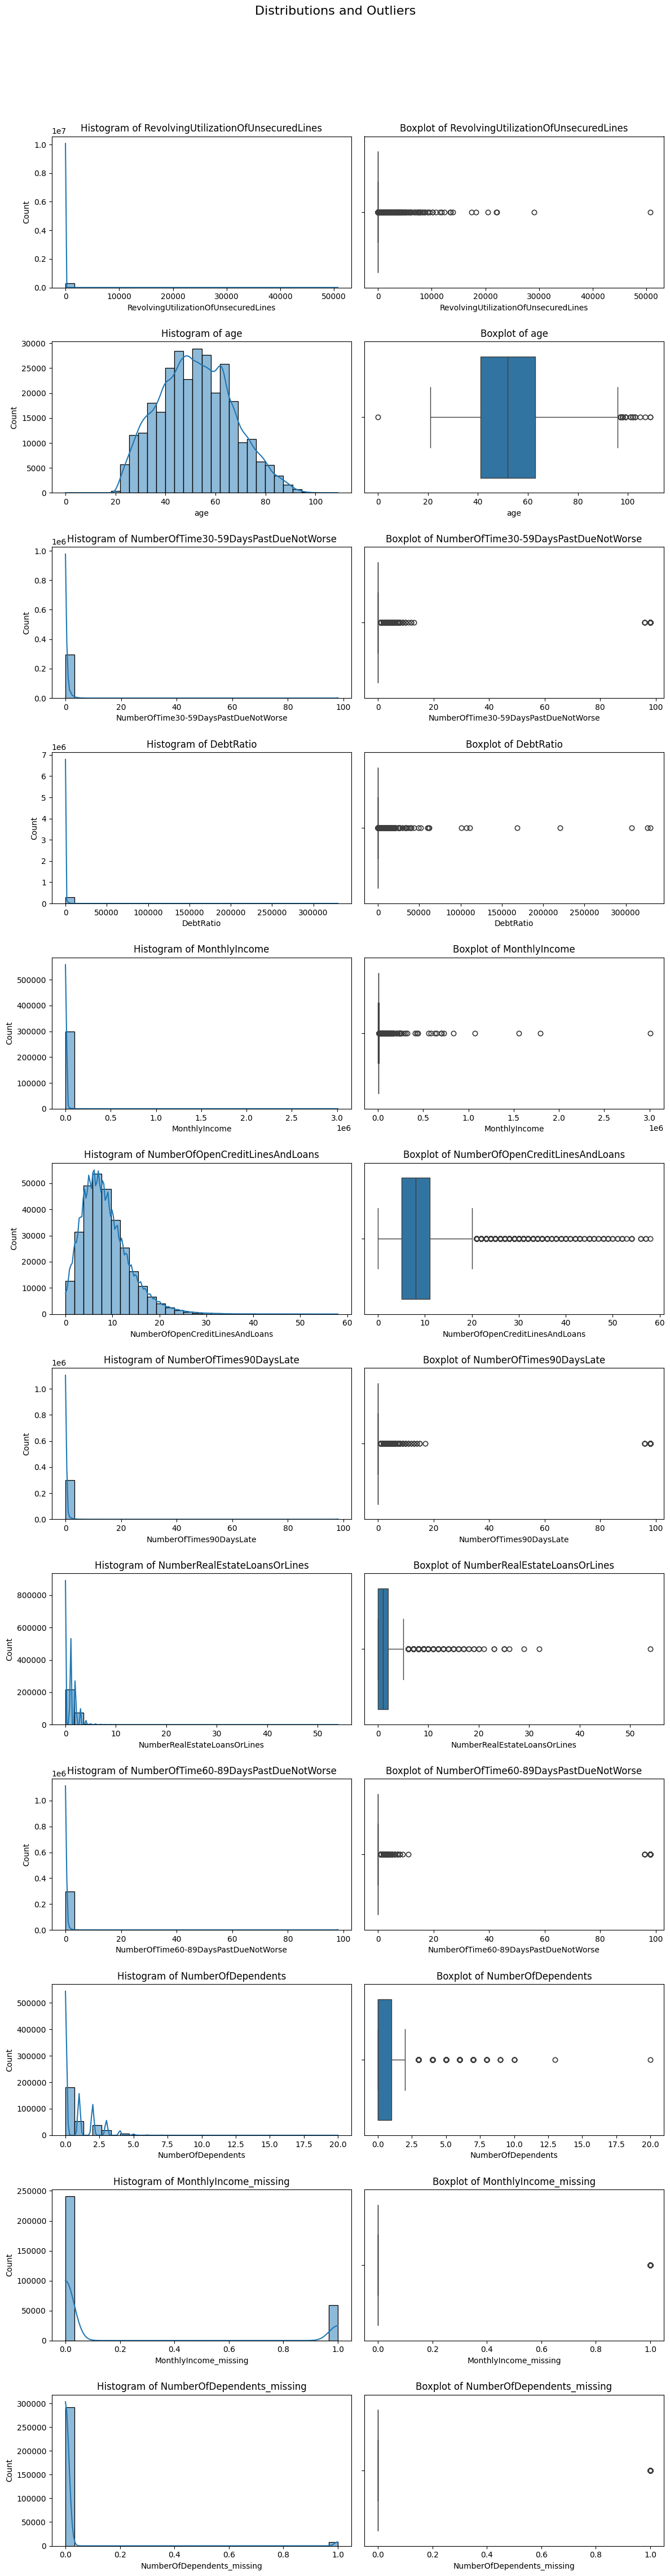

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler

# ==========================================
# STEP 2 & 3: EDA VISUALIZATION & CLEANING
# ==========================================

# 1. Visualizing Distributions (Boxplots & Histograms)
# We filter numeric columns to avoid errors
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [c for c in numeric_cols if c != 'SeriousDlqin2yrs'] # Exclude target

# Set up the plot grid
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 4 * len(numeric_cols)))
fig.suptitle('Distributions and Outliers', fontsize=16)

for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Cleaning late columns:
If you see a spike at 96/98, you should likely replace them with the median or max normal value, or treat them as a separate category.
In credit scoring systems, these are typically error codes or "refused to answer" markers, not actual counts of late payments.

In [0]:
# 2. Cleaning "Late" Columns (96/98)
# 96 and 98 are standard codes for "Unverified" or "Other" in this dataset, not actual counts.
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 
             'NumberOfTime60-89DaysPastDueNotWorse', 
             'NumberOfTimes90DaysLate']

print("--- Checking 96/98 Anomalies ---")
for col in late_cols:
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts().sort_index().tail(5)) # Check the tail for 96/98

# Strategy: Replace 96/98 with NaN, then fill with Median (more robust than 0)
for col in late_cols:
    df[col] = df[col].replace({96: np.nan, 98: np.nan})
    df[col] = df[col].fillna(df[col].median())
    print(f"Fixed {col}. Max value is now: {df[col].max()}")

--- Checking 96/98 Anomalies ---

Value Counts for NumberOfTime30-59DaysPastDueNotWorse:
NumberOfTime30-59DaysPastDueNotWorse
11      2
12      4
13      2
96     10
98    528
Name: count, dtype: int64

Value Counts for NumberOfTime60-89DaysPastDueNotWorse:
NumberOfTime60-89DaysPastDueNotWorse
8       4
9       2
11      2
96     10
98    528
Name: count, dtype: int64

Value Counts for NumberOfTimes90DaysLate:
NumberOfTimes90DaysLate
14      4
15      4
17      2
96     10
98    528
Name: count, dtype: int64
Fixed NumberOfTime30-59DaysPastDueNotWorse. Max value is now: 13.0
Fixed NumberOfTime60-89DaysPastDueNotWorse. Max value is now: 11.0
Fixed NumberOfTimes90DaysLate. Max value is now: 17.0


## Dealing with Age 0

In [0]:
# 3. Cleaning Age 0
print("\n--- Checking Age 0 ---")
zero_age_count = df[df['age'] == 0].shape[0]
print(f"Count of Age 0: {zero_age_count}")

if zero_age_count < 100: # If very few, drop them
    print("Dropping rows with Age 0...")
    df = df[df['age'] > 0]
else: # If many, impute with median
    print("Imputing Age 0 with Median...")
    df.loc[df['age'] == 0, 'age'] = df['age'].median()


--- Checking Age 0 ---
Count of Age 0: 2
Dropping rows with Age 0...


# Step 3: Feature Engineering

## Add new calculated valuable features

In [0]:
# 1. Income Per Person
# (Adding 1 to dependents to avoid division by zero if dependents=0)
df['IncomePerPerson'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)

# 2. Total Past Due
# Summing all late instances to get a "Total Bad Behavior" score
df['Total_Past_Due'] = df[late_cols].sum(axis=1)

# 3. Net Wealth Proxy (Income weighted by Debt)
# Using a simple inversion: Income * (1 - DebtRatio)
# Note: DebtRatio can be > 1, so we clip it for this specific interaction to make sense
df['Net_Wealth_Proxy'] = df['MonthlyIncome'] * (1 - df['DebtRatio'].clip(upper=1))

print("\nFeature Engineering Complete. New Columns Added.")


Feature Engineering Complete. New Columns Added.


## Multilinearity check

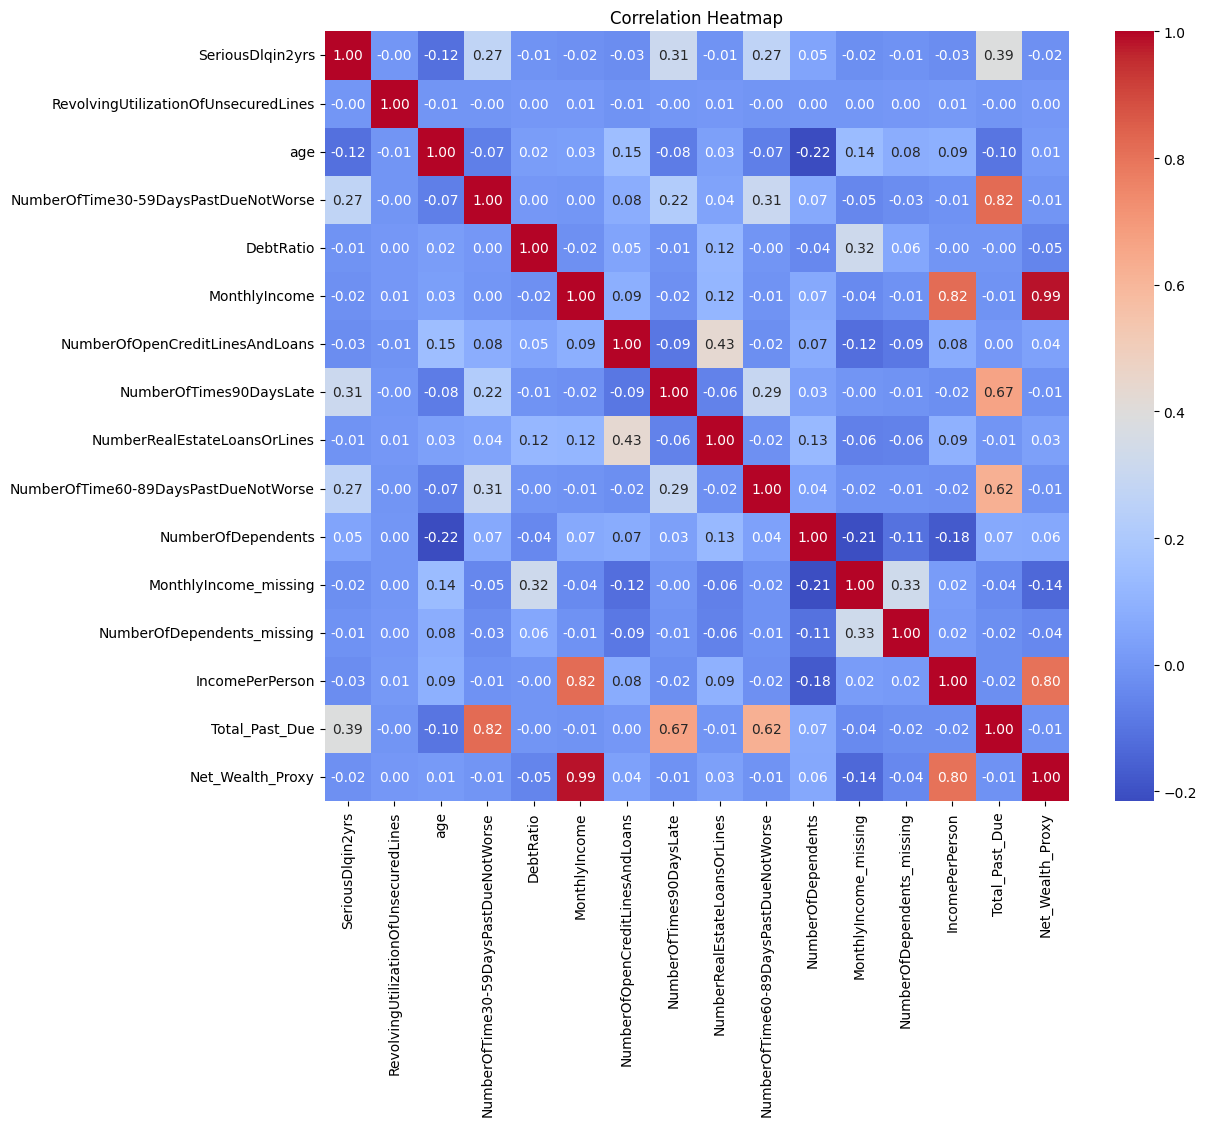


Correlation between Late Columns:
                                      NumberOfTime30-59DaysPastDueNotWorse  ...  NumberOfTimes90DaysLate
NumberOfTime30-59DaysPastDueNotWorse                              1.000000  ...                 0.218235
NumberOfTime60-89DaysPastDueNotWorse                              0.305958  ...                 0.294684
NumberOfTimes90DaysLate                                           0.218235  ...                 1.000000

[3 rows x 3 columns]


In [0]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Check specific correlation between late columns
print("\nCorrelation between Late Columns:")
print(df[late_cols].corr())

# Step 4: Train-test split and Model pipeline divide

## Train-test split - stratified

In [0]:
X = df.drop("SeriousDlqin2yrs", axis=1)
y = df["SeriousDlqin2yrs"]

# Stratified Split ensures the % of defaulters is same in Train and Test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"\nSplit Complete. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")
print(f"Default Rate in Train: {y_train.mean():.4f}")
print(f"Default Rate in Test:  {y_test.mean():.4f}")


Split Complete. Train Shape: (239998, 15), Test Shape: (60000, 15)
Default Rate in Train: 0.0668
Default Rate in Test:  0.0668


## Two model pipeline creation(only change codes from this step, if change, contact group members who work on models in the same pipiline):  
Pipeline A: Random Forest, Decicion Tree, XGB/LightGBM  
Pipeline B: LogReg, NN  
Pipeline A models no need for scaling, standardization, binning, and winsordization, while pipeline B models need.  

In [0]:
# ==========================================
# PIPELINE CREATION
# ==========================================

# --- PIPELINE A: TREE MODELS (RF, XGB, LightGBM) ---
# Trees generally perform better with raw, unscaled data.
# They handle outliers by splitting, so we don't cap them heavily.
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

# (Optional) Mild capping for tree models just to remove sanity-breaking errors
# e.g., DebtRatio > 100,000 is likely a data error, capping it helps even trees.
X_train_tree.loc[X_train_tree['DebtRatio'] > 100000, 'DebtRatio'] = 100000
X_test_tree.loc[X_test_tree['DebtRatio'] > 100000, 'DebtRatio'] = 100000

print("\nPipeline A (Tree Data) Ready: X_train_tree, X_test_tree")

# ============================================================
# IMPROVED PIPELINE B
# ============================================================
def build_pipeline_B(X_train, X_test):

    X_train_b = X_train.copy()
    X_test_b = X_test.copy()

    cols_to_cap = [
        'RevolvingUtilizationOfUnsecuredLines',
        'DebtRatio',
        'MonthlyIncome',
        'IncomePerPerson'
    ]

    for col in cols_to_cap:
        lower = X_train_b[col].quantile(0.01)
        upper = X_train_b[col].quantile(0.99)

        X_train_b[col] = X_train_b[col].clip(lower, upper)
        X_test_b[col]  = X_test_b[col].clip(lower, upper)

    bins = [-1, 30, 45, 60, 75, 120]
    labels = [0, 1, 2, 3, 4]

    X_train_b['Age_Group'] = pd.cut(X_train_b['age'], bins=bins, labels=labels).astype(int)
    X_test_b['Age_Group']  = pd.cut(X_test_b['age'], bins=bins, labels=labels).astype(int)

    # Add Age squared
    X_train_b['Age_Sq'] = X_train_b['age'] ** 2
    X_test_b['Age_Sq']  = X_test_b['age'] ** 2

    # Drop raw age to avoid multicollinearity
    X_train_b.drop('age', axis=1, inplace=True)
    X_test_b.drop('age', axis=1, inplace=True)

    late_cols = [
        'NumberOfTime30-59DaysPastDueNotWorse',
        'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfTimes90DaysLate'
    ]

    X_train_b = X_train_b.drop(columns=late_cols)
    X_test_b  = X_test_b.drop(columns=late_cols)

    X_train_b['MonthlyIncome_log'] = np.log1p(X_train_b['MonthlyIncome'])
    X_test_b['MonthlyIncome_log']  = np.log1p(X_test_b['MonthlyIncome'])

    X_train_b['DebtRatio_log'] = np.log1p(X_train_b['DebtRatio'])
    X_test_b['DebtRatio_log']  = np.log1p(X_test_b['DebtRatio'])

    # DebtRatio squared
    X_train_b['DebtRatio_sq'] = X_train_b['DebtRatio'] ** 2
    X_test_b['DebtRatio_sq']  = X_test_b['DebtRatio'] ** 2

    X_train_b['Util_x_PastDue'] = (
        X_train_b['RevolvingUtilizationOfUnsecuredLines'] * X_train_b['Total_Past_Due']
    )
    X_test_b['Util_x_PastDue'] = (
        X_test_b['RevolvingUtilizationOfUnsecuredLines'] * X_test_b['Total_Past_Due']
    )


    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_b),
        columns=X_train_b.columns,
        index=X_train_b.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_b),
        columns=X_test_b.columns,
        index=X_test_b.index
    )

    return X_train_scaled, X_test_scaled



# ===========================================================
# PIPELINE B2 (FOR NEURAL NETWORK ONLY)
# Light preprocessing: keep ALL features; only minimal clipping + scaling
# ===========================================================

X_train_nn = X_train.copy()
X_test_nn = X_test.copy()

# 1. Light outlier capping (0.1%–99.9%)
cols_clip = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 'IncomePerPerson']
for col in cols_clip:
    lower = X_train_nn[col].quantile(0.001)
    upper = X_train_nn[col].quantile(0.999)
    X_train_nn[col] = X_train_nn[col].clip(lower, upper)
    X_test_nn[col] = X_test_nn[col].clip(lower, upper)

# 2. KEEP ALL raw features (DO NOT DROP late columns, DO NOT bin age)
# NN learns non-linear interactions → keep everything

# 3. Standard Scaling (BEST for NN)
from sklearn.preprocessing import StandardScaler
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_nn)
X_test_nn = scaler_nn.transform(X_test_nn)

print("\nNeural Network Pipeline Ready: X_train_nn, X_test_nn")



Pipeline A (Tree Data) Ready: X_train_tree, X_test_tree

Neural Network Pipeline Ready: X_train_nn, X_test_nn


## Business Ojbective (professor's feedback)

In [0]:
def get_business_metrics(y_true, y_probs):
    """
    Calculates business metrics and optimal strategies based on probabilities.
    Returns a dictionary containing both the strategies and the raw arrays for plotting.
    """
    # 1. Assumptions
    LOAN_AMT = 10000
    MARGIN = 0.10
    LOSS = 1.00
    
    # 2. Loop thresholds
    thresholds = np.linspace(0, 1, 101)
    profits = []
    def_rates = []
    appr_rates = []
    
    # Pre-calculate totals for speed
    n_total = len(y_true)
    
    for t in thresholds:
        y_pred_t = (y_probs >= t).astype(int)
        
        # Vectorized calculations are faster than loops
        TN = np.sum((y_true == 0) & (y_pred_t == 0))
        FN = np.sum((y_true == 1) & (y_pred_t == 0))
        # TP and FP are not used in this specific profit calc, but usually good to have
        # TP = np.sum((y_true == 1) & (y_pred_t == 1))
        # FP = np.sum((y_true == 0) & (y_pred_t == 1))
        
        # Profit Logic provided by user
        profit = (TN * LOAN_AMT * MARGIN) - (FN * LOAN_AMT * LOSS)
        profits.append(profit)
        
        approvals = TN + FN
        appr_rate = approvals / n_total if n_total > 0 else 0
        
        # Portfolio Risk (Default Rate among approvals)
        def_rate = FN / approvals if approvals > 0 else 0
        
        appr_rates.append(appr_rate)
        def_rates.append(def_rate)
        
    # Convert to arrays for indexing
    profits = np.array(profits)
    def_rates = np.array(def_rates)
    appr_rates = np.array(appr_rates)
        
    # 3. Find Strategies
    
    # A. Balanced (Max Profit)
    idx_bal = np.argmax(profits)
    
    # B. Conservative (Risk < 1.5%)
    safe_idxs = np.where(def_rates <= 0.01)[0]
    # If no strategy meets criteria, fallback to balanced
    if len(safe_idxs) > 0:
        idx_cons = safe_idxs[np.argmax(profits[safe_idxs])]
    else:
        idx_cons = idx_bal
    
    # C. Aggressive (Scale > 93%)
    grow_idxs = np.where(appr_rates >= 0.9)[0]
    if len(grow_idxs) > 0:
        idx_agg = grow_idxs[np.argmax(profits[grow_idxs])]
    else:
        idx_agg = idx_bal

    # Return structured data
    return {
        "strategies": {
            "Balanced": {"Thresh": thresholds[idx_bal], "Profit": profits[idx_bal], "Risk": def_rates[idx_bal], "Scale": appr_rates[idx_bal]},
            "Conservative": {"Thresh": thresholds[idx_cons], "Profit": profits[idx_cons], "Risk": def_rates[idx_cons], "Scale": appr_rates[idx_cons]},
            "Aggressive": {"Thresh": thresholds[idx_agg], "Profit": profits[idx_agg], "Risk": def_rates[idx_agg], "Scale": appr_rates[idx_agg]}
        },
        "arrays": {
            "thresholds": thresholds,
            "profits": profits,
            "def_rates": def_rates,
            "appr_rates": appr_rates
        }
    }


In [0]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
    f1_score,
    brier_score_loss
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
from tqdm import tqdm
from contextlib import contextmanager
import joblib
import os

In [0]:
# This installs xgboost and ensures other viz libraries are present
%pip install xgboost seaborn matplotlib scikit-learn pandas numpy scipy
%pip install tqdm


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## Decision Tree

In [0]:
# ------------------------------------------
# 1. DECISION TREE TUNING (SCIENTIFIC + TIME-SAVING) — CACHED
# ------------------------------------------

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier


from scipy.stats import randint
from tqdm import tqdm
from contextlib import contextmanager
import joblib
import os

# Databricks-safe tqdm wrapper
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

DT_MODEL_PATH = "decision_tree_final_model.joblib"

print("\n======================")
print("Decision Tree Pipeline")
print("======================")

if os.path.exists(DT_MODEL_PATH):
    print(f"Loading cached Decision Tree model from {DT_MODEL_PATH} (no re-training)...")
    dt_best_model = joblib.load(DT_MODEL_PATH)

else:
    print("No cached DT model found — running scientific hyperparameter tuning...")

    dt_param_dist = {
        'max_depth': randint(3, 20),
        'min_samples_split': randint(20, 300),
        'min_samples_leaf': randint(10, 200),
        'criterion': ['gini', 'entropy'],
    }

    dt_clf = DecisionTreeClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    dt_search = RandomizedSearchCV(
        dt_clf,
        param_distributions=dt_param_dist,
        n_iter=20,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        verbose=0
    )

    with tqdm_joblib(tqdm(desc="DT Tuning Progress", total=20 * 3)):
        dt_search.fit(X_train_tree, y_train)

    dt_best_model = dt_search.best_estimator_

    # Training AUC for summary
    dt_train_proba = dt_best_model.predict_proba(X_train_tree)[:, 1]
    dt_train_auc = roc_auc_score(y_train, dt_train_proba)

    # Save tuned model
    joblib.dump(dt_best_model, DT_MODEL_PATH)

    # Print summary exactly like XGB
    print("\n===== DECISION TREE TUNING SUMMARY =====")
    print(f"Best DT AUC: {dt_train_auc:.4f}")
    print(f"Best Parameters: {dt_search.best_params_}")
    print(f"Saved tuned model to {DT_MODEL_PATH}")
    print("========================================\n")



Decision Tree Pipeline
No cached DT model found — running scientific hyperparameter tuning...


DT Tuning Progress: 100%|██████████| 60/60 [00:45<00:00,  1.30it/s]


===== DECISION TREE TUNING SUMMARY =====
Best DT AUC: 0.8953
Best Parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 199, 'min_samples_split': 232}
Saved tuned model to decision_tree_final_model.joblib



In [0]:
# ------------------------------------------
# 2. PREDICT PROBABILITIES (CACHED)
# ------------------------------------------

DT_PROBA_PATH = "decision_tree_pred_proba.joblib"

if os.path.exists(DT_PROBA_PATH):
    print(f"Loading cached Decision Tree probabilities from {DT_PROBA_PATH} ...")
    dt_pred_proba = joblib.load(DT_PROBA_PATH)
else:
    print("Generating Decision Tree predicted probabilities on test set...")
    dt_pred_proba = dt_best_model.predict_proba(X_test_tree)[:, 1]

    joblib.dump(dt_pred_proba, DT_PROBA_PATH)
    print(f"Decision Tree probabilities saved to: {DT_PROBA_PATH}")

Generating Decision Tree predicted probabilities on test set...
Decision Tree probabilities saved to: decision_tree_pred_proba.joblib


In [0]:
# ------------------------------------------
# 3. THRESHOLD OPTIMIZATION + BUSINESS METRICS
# ------------------------------------------

# A. Technical F1 threshold tuning (same style as XGB)
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_temp = (dt_pred_proba >= t).astype(int)
    tp = np.sum((y_test == 1) & (y_pred_temp == 1))
    fp = np.sum((y_test == 0) & (y_pred_temp == 1))
    fn = np.sum((y_test == 1) & (y_pred_temp == 0))

    precision_t = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision_t * recall_t) / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)
max_f1_idx = np.argmax(f1_scores)
dt_optimal_threshold = thresholds[max_f1_idx]
dt_max_f1 = f1_scores[max_f1_idx]
dt_pred_optimal = (dt_pred_proba >= dt_optimal_threshold).astype(int)

# B. Business metrics using your function (unchanged)
dt_biz_metrics = get_business_metrics(y_test, dt_pred_proba)
dt_strat = dt_biz_metrics['strategies']
dt_arrays = dt_biz_metrics['arrays']

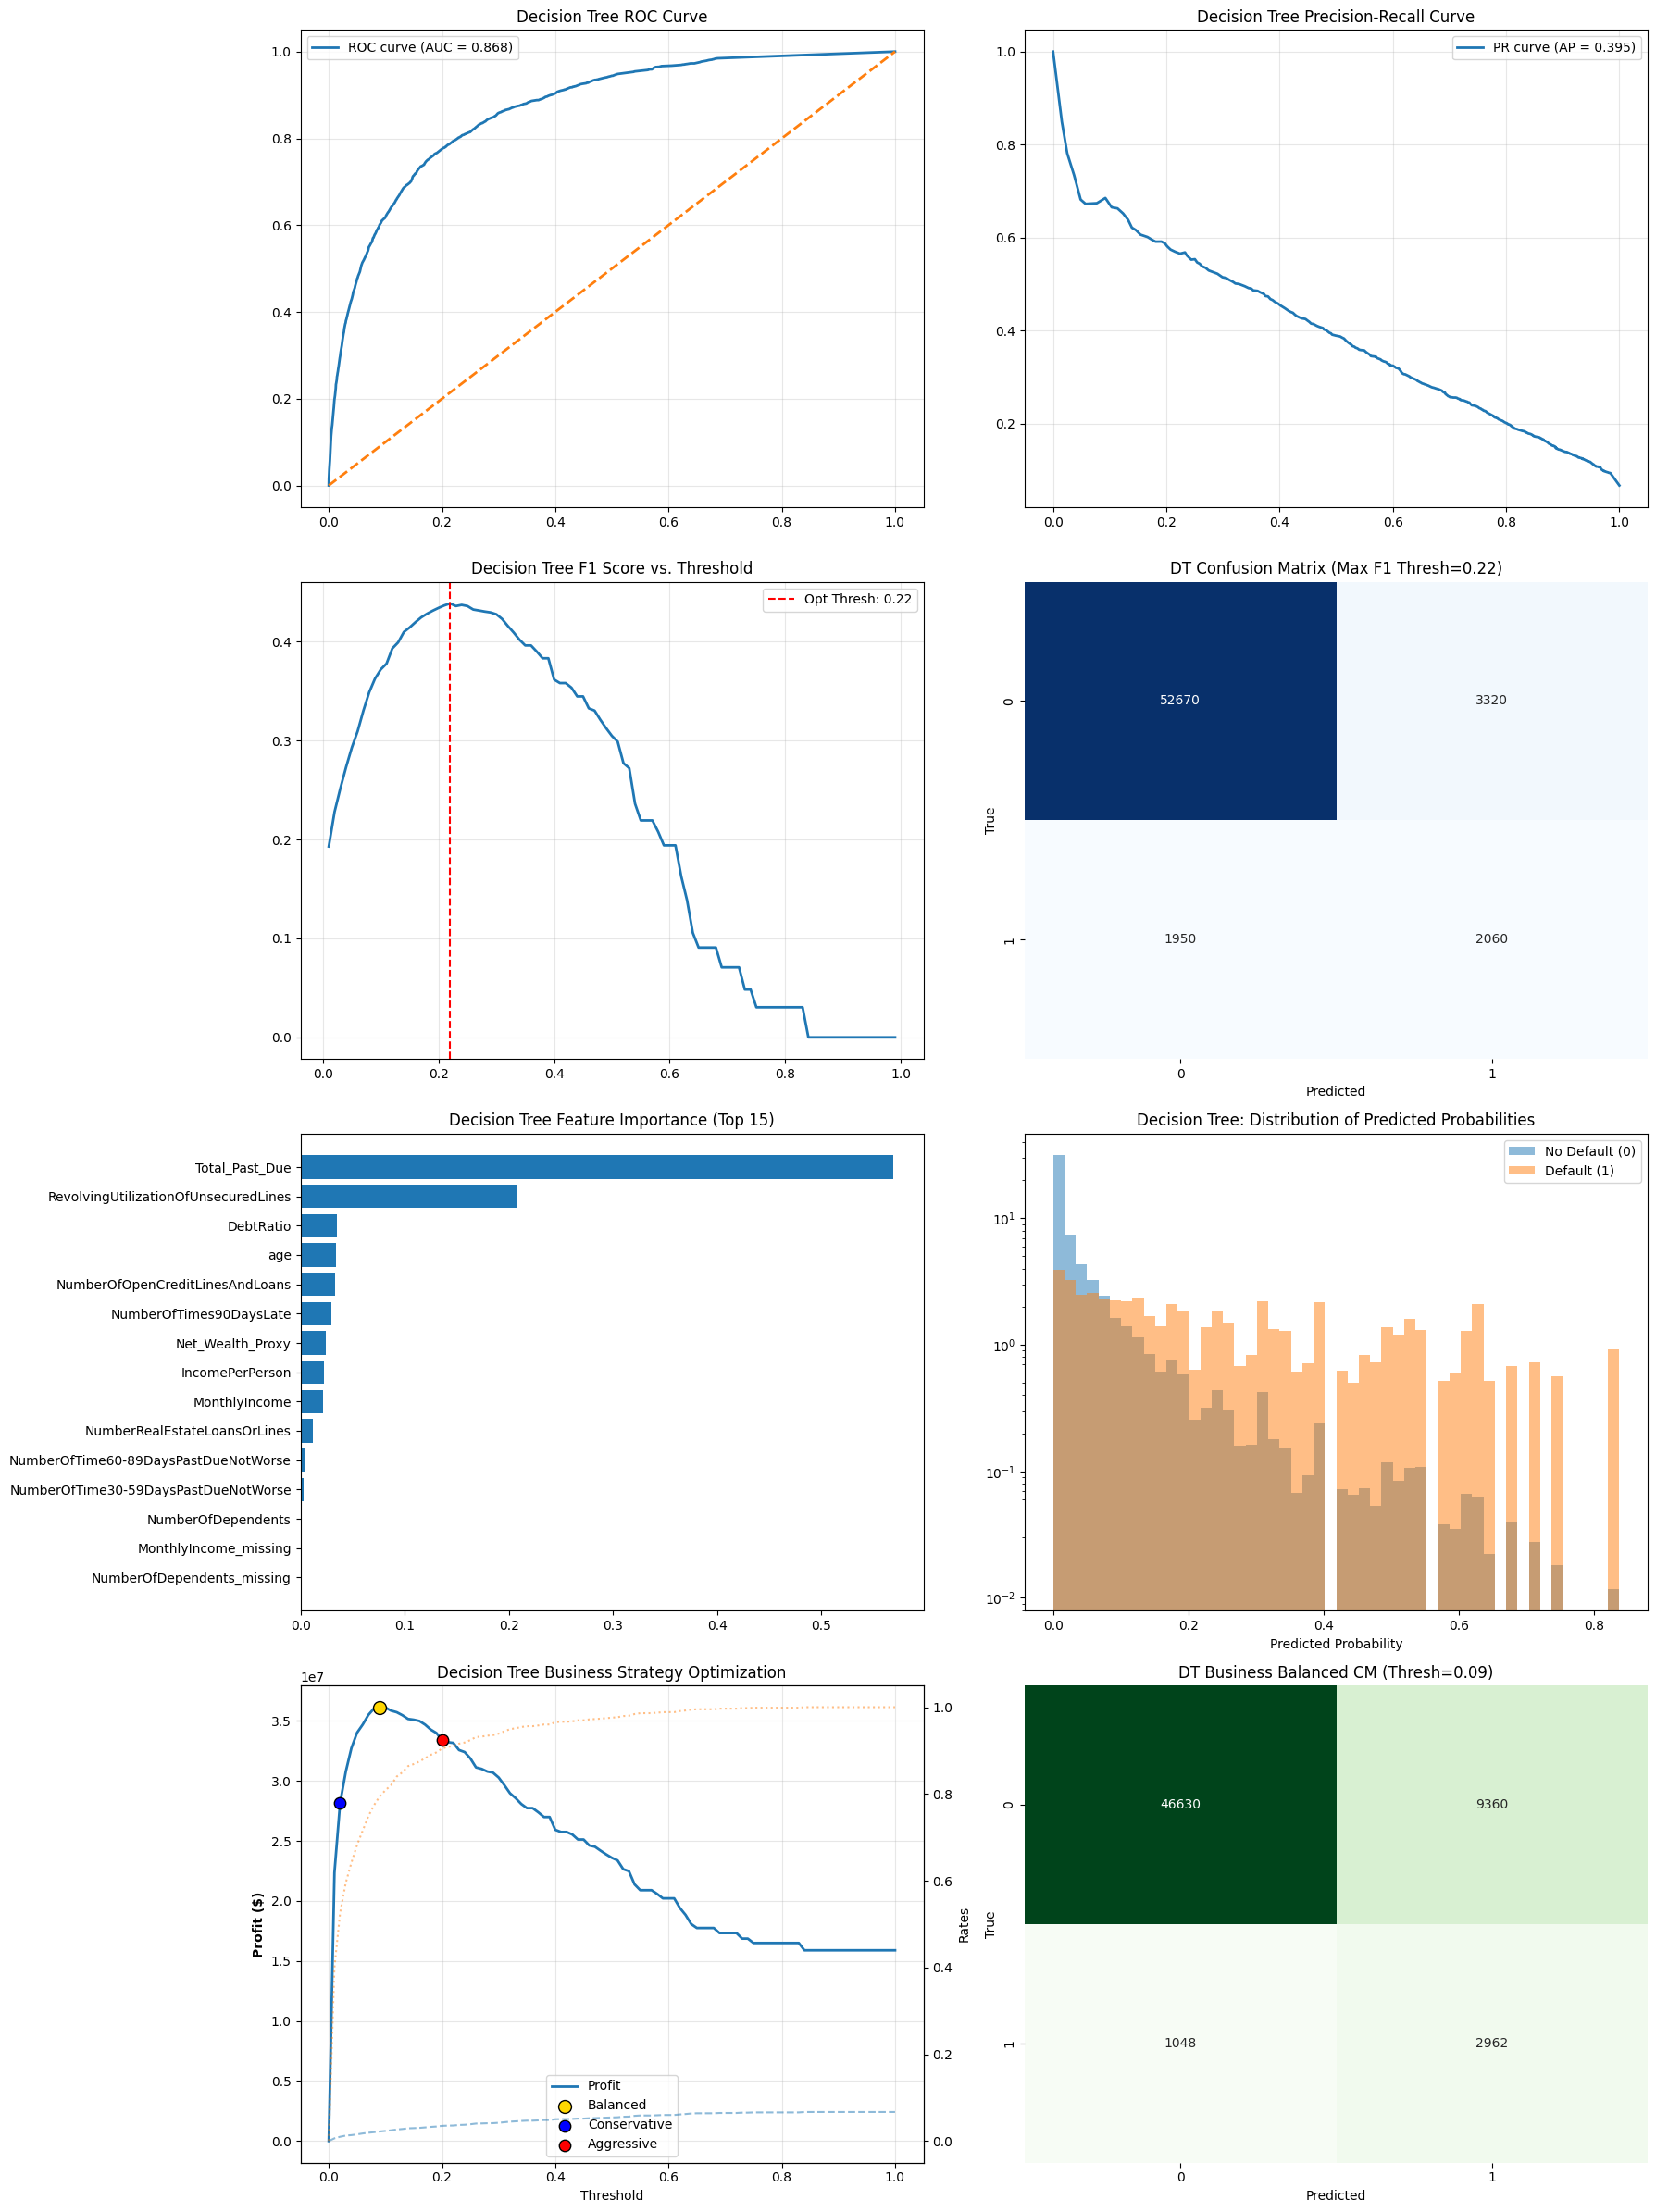

DECISION TREE - FINAL MODEL RESULTS (TECHNICAL)
Optimal Threshold (F1): 0.2200
Max F1 Score:          0.4388
ROC-AUC Score:         0.8678
PR-AUC Score:          0.3948
Brier Score:           0.0493

Classification Report (at F1 optimal threshold):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     55990
           1       0.38      0.51      0.44      4010

    accuracy                           0.91     60000
   macro avg       0.67      0.73      0.70     60000
weighted avg       0.93      0.91      0.92     60000


DECISION TREE - OPTIMIZED BUSINESS STRATEGIES
STRATEGY        | THRESH   | PROFIT       | RISK       | SCALE     
-----------------------------------------------------------------
Balanced        | 0.09     | $36,150,000   | 2.20%     | 79.46%
Conservative    | 0.02     | $28,144,000   | 0.98%     | 52.55%
Aggressive      | 0.20     | $33,412,000   | 3.49%     | 90.46%

Decision Tree predictions saved to: decision_tree_

In [0]:
# ------------------------------------------
# 4. VISUALIZATIONS (4 ROWS, PARALLEL TO XGB)
# ------------------------------------------

fig, axes = plt.subplots(4, 2, figsize=(18, 24))
plt.subplots_adjust(hspace=0.4)

# --- Row 1: ROC & PR ---
fpr, tpr, _ = roc_curve(y_test, dt_pred_proba)
dt_auc = roc_auc_score(y_test, dt_pred_proba)
axes[0, 0].plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {dt_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[0, 0].set_title('Decision Tree ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, dt_pred_proba)
dt_pr_auc = average_precision_score(y_test, dt_pred_proba)
axes[0, 1].plot(recall, precision, lw=2, label=f'PR curve (AP = {dt_pr_auc:.3f})')
axes[0, 1].set_title('Decision Tree Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- Row 2: F1 Threshold & Technical Confusion Matrix ---
axes[1, 0].plot(thresholds, f1_scores, lw=2)
axes[1, 0].axvline(dt_optimal_threshold, color='red', linestyle='--',
                   label=f'Opt Thresh: {dt_optimal_threshold:.2f}')
axes[1, 0].set_title('Decision Tree F1 Score vs. Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

cm_tech = confusion_matrix(y_test, dt_pred_optimal)
sns.heatmap(cm_tech, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title(f'DT Confusion Matrix (Max F1 Thresh={dt_optimal_threshold:.2f})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# --- Row 3: Feature Importance & Probability Distribution ---
importances = dt_best_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # Top 15 features

axes[2, 0].barh(range(len(indices)), importances[indices], align='center')
axes[2, 0].set_yticks(range(len(indices)))
axes[2, 0].set_yticklabels([X_train_tree.columns[i] for i in indices])
axes[2, 0].invert_yaxis()
axes[2, 0].set_title('Decision Tree Feature Importance (Top 15)')

prob_default = dt_pred_proba[y_test == 1]
prob_no_default = dt_pred_proba[y_test == 0]
axes[2, 1].hist(prob_no_default, bins=50, alpha=0.5, label='No Default (0)', density=True)
axes[2, 1].hist(prob_default, bins=50, alpha=0.5, label='Default (1)', density=True)
axes[2, 1].set_xlabel('Predicted Probability')
axes[2, 1].set_yscale('log')
axes[2, 1].set_title('Decision Tree: Distribution of Predicted Probabilities')
axes[2, 1].legend()

# --- Row 4: Business Strategy Curves & Business Confusion Matrix ---
ax_biz = axes[3, 0]
ax_biz.set_xlabel('Threshold')
ax_biz.set_ylabel('Profit ($)', fontweight='bold')
ax_biz.plot(dt_arrays['thresholds'], dt_arrays['profits'], lw=2, label='Profit')
ax_biz.tick_params(axis='y')
ax_biz.grid(True, alpha=0.3)

# Mark Business Strategy Points
ax_biz.scatter(dt_strat['Balanced']['Thresh'], dt_strat['Balanced']['Profit'],
               color='gold', s=100, edgecolors='black', zorder=5, label='Balanced')
ax_biz.scatter(dt_strat['Conservative']['Thresh'], dt_strat['Conservative']['Profit'],
               color='blue', s=80, edgecolors='black', zorder=5, label='Conservative')
ax_biz.scatter(dt_strat['Aggressive']['Thresh'], dt_strat['Aggressive']['Profit'],
               color='red', s=80, edgecolors='black', zorder=5, label='Aggressive')

ax_biz2 = ax_biz.twinx()
ax_biz2.plot(dt_arrays['thresholds'], dt_arrays['def_rates'],
             linestyle='--', alpha=0.5, label='Risk')
ax_biz2.plot(dt_arrays['thresholds'], dt_arrays['appr_rates'],
             linestyle=':', alpha=0.5, label='Scale')
ax_biz2.set_ylabel('Rates')

ax_biz.legend(loc='lower center')
ax_biz.set_title("Decision Tree Business Strategy Optimization")

# Business Confusion Matrix at Balanced strategy
bal_thresh_dt = dt_strat['Balanced']['Thresh']
y_pred_bal_dt = (dt_pred_proba >= bal_thresh_dt).astype(int)
cm_biz_dt = confusion_matrix(y_test, y_pred_bal_dt)
sns.heatmap(cm_biz_dt, annot=True, fmt='d', cmap='Greens', ax=axes[3, 1], cbar=False)
axes[3, 1].set_title(f'DT Business Balanced CM (Thresh={bal_thresh_dt:.2f})')
axes[3, 1].set_xlabel('Predicted')
axes[3, 1].set_ylabel('True')

plt.tight_layout()
plt.show()


# ------------------------------------------
# 5. FINAL REPORTS + SAVED PREDICTIONS
# ------------------------------------------

# Metrics at F1-optimal threshold
print("=" * 50)
print("DECISION TREE - FINAL MODEL RESULTS (TECHNICAL)")
print("=" * 50)
print(f"Optimal Threshold (F1): {dt_optimal_threshold:.4f}")
print(f"Max F1 Score:          {dt_max_f1:.4f}")
print(f"ROC-AUC Score:         {dt_auc:.4f}")
print(f"PR-AUC Score:          {dt_pr_auc:.4f}")
print(f"Brier Score:           {brier_score_loss(y_test, dt_pred_proba):.4f}")

print("\nClassification Report (at F1 optimal threshold):")
print(classification_report(y_test, dt_pred_optimal))

print("\n" + "=" * 50)
print("DECISION TREE - OPTIMIZED BUSINESS STRATEGIES")
print("=" * 50)
print(f"{'STRATEGY':<15} | {'THRESH':<8} | {'PROFIT':<12} | {'RISK':<10} | {'SCALE':<10}")
print("-" * 65)
for name, data in dt_strat.items():
    print(f"{name:<15} | {data['Thresh']:.2f}     | ${data['Profit']:,.0f}   | "
          f"{data['Risk']:.2%}     | {data['Scale']:.2%}")

# Save prediction results (parallel to your old block)
dt_results = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_F1opt": dt_pred_optimal,
    "y_prob": dt_pred_proba
}, index=y_test.index)

dt_results_path = "decision_tree_predictions.csv"
dt_results.to_csv(dt_results_path, index=False)
print(f"\nDecision Tree predictions saved to: {dt_results_path}")

## Random Forest

In [0]:
# -----------------------------
# FAST & CLEAN Random Forest Tuning
# -----------------------------
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import randint
from tqdm import tqdm
from contextlib import contextmanager

# tqdm_joblib for Databricks (correct total = n_iter * cv_splits)
@contextmanager
def tqdm_joblib(tqdm_object):
    import joblib.parallel
    old = joblib.parallel.BatchCompletionCallBack

    class TqdmCallback(old):
        def __call__(self, *args, **kwargs):
            tqdm_object.update()
            return super().__call__(*args, **kwargs)

    joblib.parallel.BatchCompletionCallBack = TqdmCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old
        tqdm_object.close()


RF_MODEL_PATH = "rf_best_model.joblib"
RF_PROBA_PATH = "rf_pred_proba.joblib"  # <-- ADD THIS

if os.path.exists(RF_MODEL_PATH):
    print("Loading cached Random Forest model (no re-tuning)...")
    rf_best_model = joblib.load(RF_MODEL_PATH)

else:
    print("Running FAST Random Forest hyperparameter tuning...")

    # Base model
    rf_clf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        bootstrap=True
    )

    # Scientific but small search space
    rf_param_dist = {
        "n_estimators": randint(100, 300),      # moderate forest sizes
        "max_depth": randint(5, 15),
        "min_samples_split": randint(2, 15),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", 0.3, 0.5],
        "class_weight": ["balanced_subsample"]  # good for imbalance, no warning spam
    }

    n_iter = 15     # 15 random combos
    cv_splits = 2   # 2-fold CV → 30 fits total

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    rf_search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=rf_param_dist,
        n_iter=n_iter,
        scoring="roc_auc",
        n_jobs=-1,
        cv=cv,
        verbose=0,
        random_state=42,
        return_train_score=False
    )

    total_fits = n_iter * cv_splits

    print(f"Tuning RF with {n_iter} random configs × {cv_splits}-fold CV = {total_fits} fits.")

    # Progress bar with correct total
    with tqdm_joblib(tqdm(desc="RF Tuning Progress", total=total_fits)):
        rf_search.fit(X_train_tree, y_train)

    # Best model
    rf_best_model = rf_search.best_estimator_

    # Optional: training AUC for summary
    rf_train_proba = rf_best_model.predict_proba(X_train_tree)[:, 1]
    rf_train_auc = roc_auc_score(y_train, rf_train_proba)

    # Save model
    joblib.dump(rf_best_model, RF_MODEL_PATH)

    # XGBoost-style summary
    print("\n===== RANDOM FOREST TUNING SUMMARY =====")
    print(f"Best RF CV AUC: {rf_search.best_score_:.4f}")
    print(f"Train AUC of best RF: {rf_train_auc:.4f}")
    print("Best RF Parameters:", rf_search.best_params_)
    print(f"Saved tuned Random Forest model to {RF_MODEL_PATH}")
    print("=========================================\n")


Running FAST Random Forest hyperparameter tuning...
Tuning RF with 15 random configs × 2-fold CV = 30 fits.


RF Tuning Progress: 184it [11:31,  3.76s/it]



===== RANDOM FOREST TUNING SUMMARY =====
Best RF CV AUC: 0.8923
Train AUC of best RF: 0.9598
Best RF Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 14, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 154}
Saved tuned Random Forest model to rf_best_model.joblib



In [0]:
# 2) Predict probabilities on test set (cached)
if os.path.exists(RF_PROBA_PATH):
    print("Loading cached RF predicted probabilities...")
    rf_pred_proba = joblib.load(RF_PROBA_PATH)
else:
    print("Generating RF predicted probabilities on test set...")
    rf_pred_proba = rf_best_model.predict_proba(X_test_tree)[:, 1]
    joblib.dump(rf_pred_proba, RF_PROBA_PATH)
    print(f"Saved RF probabilities to {RF_PROBA_PATH}")


Generating RF predicted probabilities on test set...
Saved RF probabilities to rf_pred_proba.joblib


In [0]:
# 3) Threshold sweep: F1 optimization (same approach as XGBoost block)
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_temp = (rf_pred_proba >= t).astype(int)
    tp = np.sum((y_test == 1) & (y_pred_temp == 1))
    fp = np.sum((y_test == 0) & (y_pred_temp == 1))
    fn = np.sum((y_test == 1) & (y_pred_temp == 0))
    precision_t = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision_t * recall_t) / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
rf_optimal_threshold = thresholds[max_f1_idx]
rf_max_f1 = f1_scores[max_f1_idx]
rf_pred_optimal = (rf_pred_proba >= rf_optimal_threshold).astype(int)

RANDOM FOREST — TECHNICAL SUMMARY
Optimal Threshold (F1): 0.6200
Max F1 Score: 0.5075
ROC-AUC Score: 0.9183
PR-AUC (Average Precision): 0.5240
Brier Score: 0.0867

Classification Report (at F1 optimal threshold):
              precision    recall  f1-score   support

           0     0.9722    0.9401    0.9559     55990
           1     0.4274    0.6244    0.5075      4010

    accuracy                         0.9190     60000
   macro avg     0.6998    0.7823    0.7317     60000
weighted avg     0.9358    0.9190    0.9259     60000


RANDOM FOREST — BUSINESS STRATEGIES
STRATEGY        | THRESH   | PROFIT       | RISK       | SCALE     
-----------------------------------------------------------------
Balanced        | 0.45     | $41,005,000   | 1.61%     | 83.01%
Conservative    | 0.32     | $40,042,000   | 0.94%     | 74.40%
Aggressive      | 0.62     | $37,576,000   | 2.78%     | 90.24%


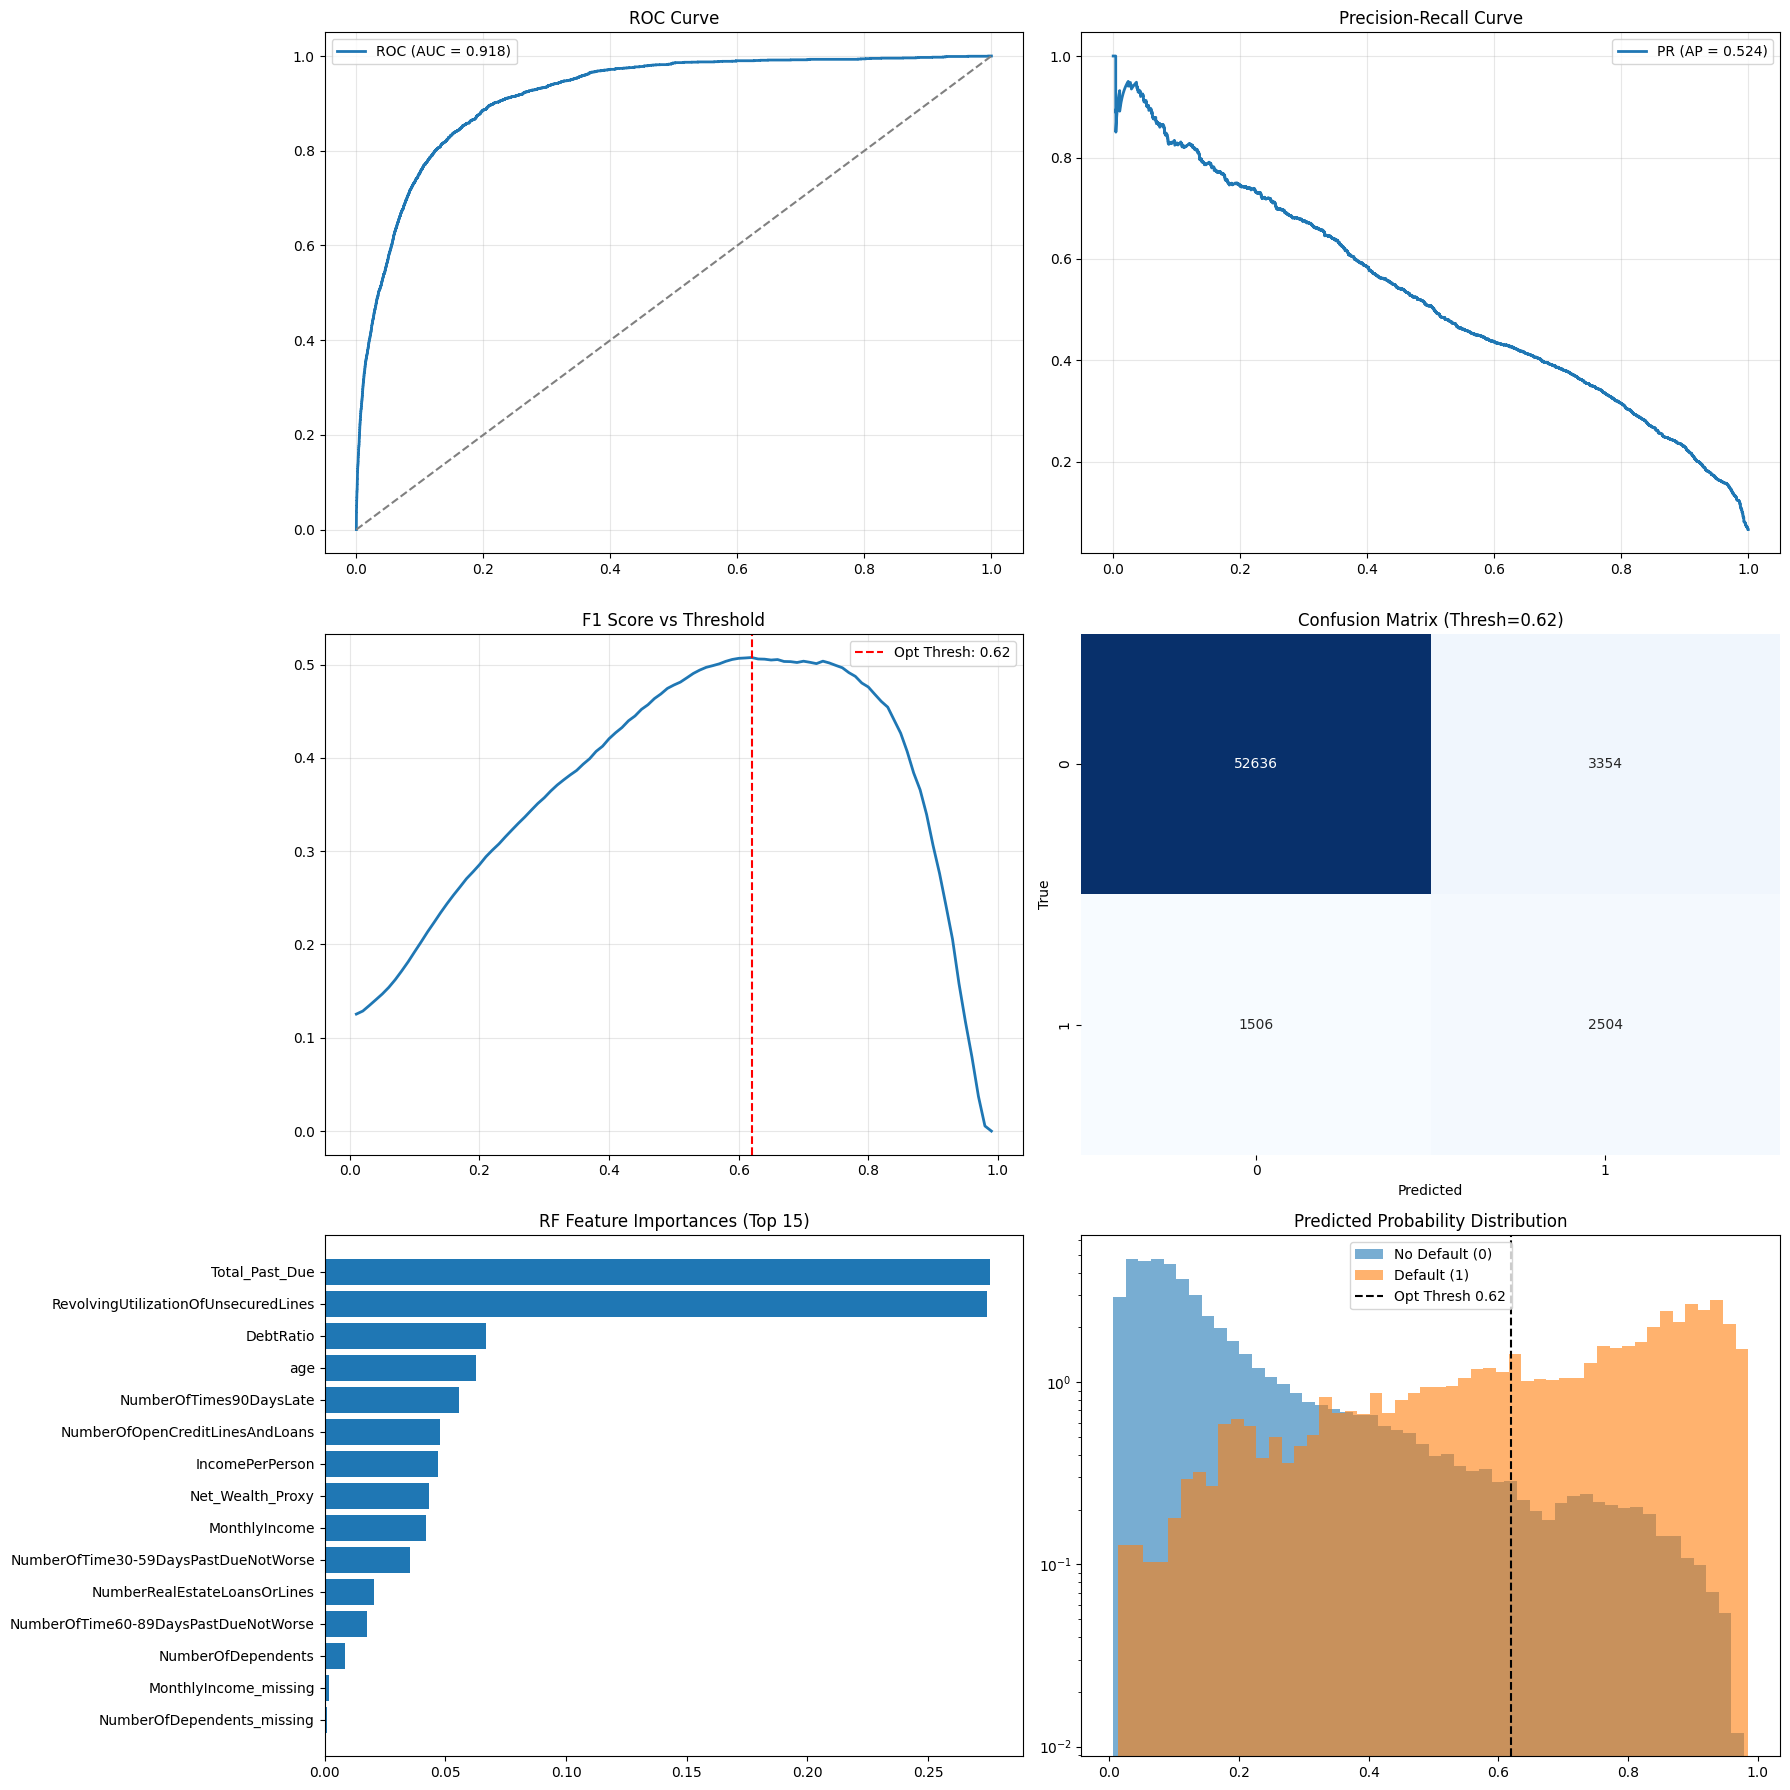

Saved RF artifacts summary to rf_artifacts_summary.joblib


In [0]:
from sklearn.metrics import auc

# 4) Business metrics using your existing function
rf_biz_metrics = get_business_metrics(y_test, rf_pred_proba)
rf_strat = rf_biz_metrics["strategies"]
rf_arrays = rf_biz_metrics["arrays"]

# 5) Technical metrics
fpr, tpr, _ = roc_curve(y_test, rf_pred_proba)
rf_auc = auc(fpr, tpr)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, rf_pred_proba)
rf_pr_auc = average_precision_score(y_test, rf_pred_proba)
rf_brier = brier_score_loss(y_test, rf_pred_proba)

# 6) Classification report & confusion matrix (at F1-optimal threshold)
rf_cm = confusion_matrix(y_test, rf_pred_optimal)
rf_clf_report = classification_report(y_test, rf_pred_optimal, digits=4)

# 7) Feature importances (top 15)
rf_importances = rf_best_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1][:15]
rf_feat_names = [X_train_tree.columns[i] for i in rf_indices]

# 8) Print summary (technical + business)
print("=" * 60)
print("RANDOM FOREST — TECHNICAL SUMMARY")
print("=" * 60)
print(f"Optimal Threshold (F1): {rf_optimal_threshold:.4f}")
print(f"Max F1 Score: {rf_max_f1:.4f}")
print(f"ROC-AUC Score: {rf_auc:.4f}")
print(f"PR-AUC (Average Precision): {rf_pr_auc:.4f}")
print(f"Brier Score: {rf_brier:.4f}")
print("\nClassification Report (at F1 optimal threshold):")
print(rf_clf_report)

print("\n" + "=" * 60)
print("RANDOM FOREST — BUSINESS STRATEGIES")
print("=" * 60)
print(f"{'STRATEGY':<15} | {'THRESH':<8} | {'PROFIT':<12} | {'RISK':<10} | {'SCALE':<10}")
print("-" * 65)
for name, data in rf_strat.items():
    print(f"{name:<15} | {data['Thresh']:.2f}     | ${data['Profit']:,.0f}   | {data['Risk']:.2%}     | {data['Scale']:.2%}")

# 9) Visualizations: 3x2 grid similar to XGBoost block
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
plt.subplots_adjust(hspace=0.4)

# ROC
axes[0, 0].plot(fpr, tpr, lw=2, label=f'ROC (AUC = {rf_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], linestyle='--', color='grey')
axes[0, 0].set_title("ROC Curve")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall
axes[0, 1].plot(recall_vals, precision_vals, lw=2, label=f'PR (AP = {rf_pr_auc:.3f})')
axes[0, 1].set_title("Precision-Recall Curve")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 vs Threshold
axes[1, 0].plot(thresholds, f1_scores, lw=2)
axes[1, 0].axvline(rf_optimal_threshold, color='red', linestyle='--', label=f'Opt Thresh: {rf_optimal_threshold:.2f}')
axes[1, 0].set_title("F1 Score vs Threshold")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Confusion Matrix at optimal threshold
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title(f'Confusion Matrix (Thresh={rf_optimal_threshold:.2f})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# Feature importance
axes[2, 0].barh(range(len(rf_indices)), rf_importances[rf_indices], align='center')
axes[2, 0].set_yticks(range(len(rf_indices)))
axes[2, 0].set_yticklabels(rf_feat_names)
axes[2, 0].invert_yaxis()
axes[2, 0].set_title("RF Feature Importances (Top 15)")

# Probability distributions (Defaulters vs Non-Defaulters)
prob_default = rf_pred_proba[y_test == 1]
prob_no_default = rf_pred_proba[y_test == 0]
axes[2, 1].hist(prob_no_default, bins=50, alpha=0.6, label='No Default (0)', density=True)
axes[2, 1].hist(prob_default, bins=50, alpha=0.6, label='Default (1)', density=True)
axes[2, 1].axvline(rf_optimal_threshold, color='black', linestyle='--', label=f'Opt Thresh {rf_optimal_threshold:.2f}')
axes[2, 1].set_yscale('log')
axes[2, 1].set_title("Predicted Probability Distribution")
axes[2, 1].legend()

plt.tight_layout()
plt.show()

# 10) Save final artifacts (already saved model & proba); also save chosen threshold & metrics
ARTIFACTS = {
    "rf_best_model_path": RF_MODEL_PATH,
    "rf_proba_path": RF_PROBA_PATH,
    "rf_optimal_threshold": rf_optimal_threshold,
    "rf_max_f1": rf_max_f1,
    "rf_auc": rf_auc,
    "rf_pr_auc": rf_pr_auc,
    "rf_brier": rf_brier,
    "rf_strat": rf_strat
}
joblib.dump(ARTIFACTS, "rf_artifacts_summary.joblib")
print("Saved RF artifacts summary to rf_artifacts_summary.joblib")

# Variables exported to notebook namespace (same naming pattern as XGBoost section)
# rf_best_model, rf_pred_proba, rf_optimal_threshold, rf_max_f1, rf_pred_optimal, rf_biz_metrics, rf_strat, rf_arrays

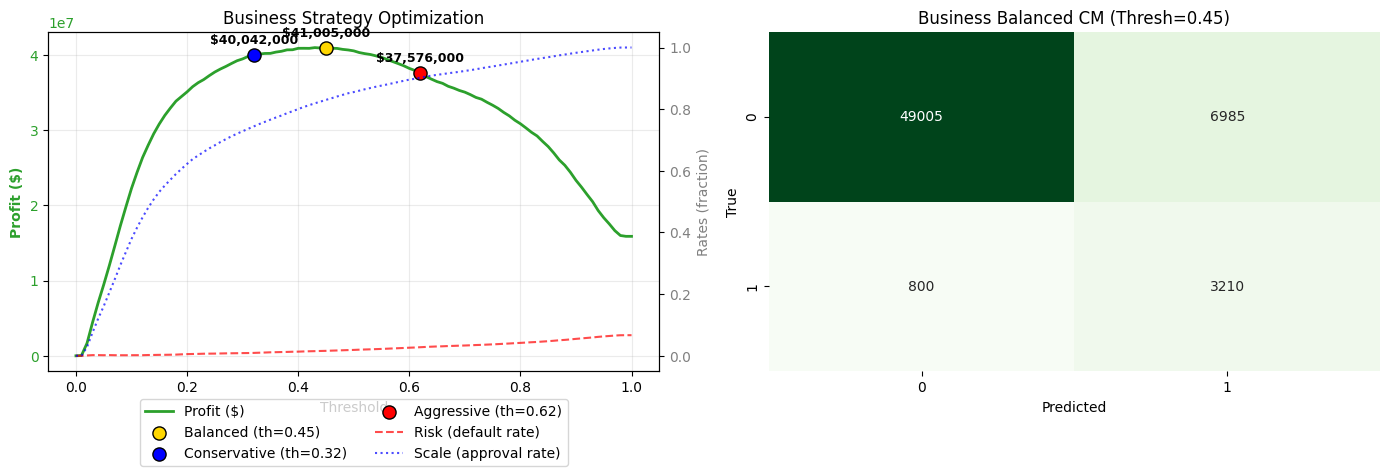

In [0]:
# -----------------------------
# Business strategy + CM (clean 1x2 figure)
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make sure rf_arrays and rf_strat and rf_pred_proba and y_test exist
# This block generates only the two business plots (no empty axes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Business Strategy Optimization (Profit / Risk / Scale) ---
ax = axes[0]
color = 'tab:green'
ax.plot(rf_arrays['thresholds'], rf_arrays['profits'], color=color, lw=2, label='Profit ($)')
ax.set_xlabel("Threshold")
ax.set_ylabel("Profit ($)", color=color, fontweight='bold')
ax.tick_params(axis='y', labelcolor=color)
ax.grid(True, alpha=0.25)

# Mark strategy points
for name, col in [("Balanced", "gold"), ("Conservative", "blue"), ("Aggressive", "red")]:
    th = rf_strat[name]["Thresh"]
    pf = rf_strat[name]["Profit"]
    ax.scatter(th, pf, color=col, edgecolors='black', s=90, zorder=5, label=f"{name} (th={th:.2f})")
    # annotate profit value above point
    ax.annotate(f"${pf:,.0f}", xy=(th, pf), xytext=(0, 8), textcoords="offset points",
                ha="center", fontsize=9, fontweight='semibold')

# Secondary axis for Risk & Scale
ax2 = ax.twinx()
ax2.plot(rf_arrays['thresholds'], rf_arrays['def_rates'], color='red', linestyle='--', alpha=0.7, label='Risk (default rate)')
ax2.plot(rf_arrays['thresholds'], rf_arrays['appr_rates'], color='blue', linestyle=':', alpha=0.7, label='Scale (approval rate)')
ax2.set_ylabel("Rates (fraction)", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Compose a combined legend (pull handles from both axes)
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)

ax.set_title("Business Strategy Optimization")

# --- Right: Business Balanced Confusion Matrix ---
axc = axes[1]
bal_thresh = rf_strat['Balanced']['Thresh']
y_pred_bal = (rf_pred_proba >= bal_thresh).astype(int)
cm_biz = confusion_matrix(y_test, y_pred_bal)

sns.heatmap(cm_biz, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axc)
axc.set_title(f'Business Balanced CM (Thresh={bal_thresh:.2f})')
axc.set_xlabel('Predicted')
axc.set_ylabel('True')

plt.tight_layout()
plt.show()

## XGBoost

In [0]:
import joblib   
# ==========================================
# 1. XGBOOST HYPERPARAMETER TUNING (CACHED)
# ==========================================
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import os

MODEL_PATH = "xgb_best_model.joblib"

if os.path.exists(MODEL_PATH):
    print("Loading cached XGBoost model (No re-tuning)...")
    xgb_best_model = joblib.load(MODEL_PATH)

else:
    print("No cached model found — running hyperparameter tuning...")

    # === Your original tuning code (unchanged) ===
    xgb_scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
    print(f"Calculated scale_pos_weight: {xgb_scale_pos_weight:.2f}")

    xgb_param_dist = {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 8),
        'min_child_weight': randint(1, 6),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'gamma': uniform(0, 0.5),
        'scale_pos_weight': [1, xgb_scale_pos_weight, xgb_scale_pos_weight * 0.5] 
    }

    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                eval_metric='auc', random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    xgb_search = RandomizedSearchCV(
        xgb_clf, param_distributions=xgb_param_dist, n_iter=15,
        scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42, verbose=0
    )

    print("Starting XGBoost Hyperparameter Tuning...")
    with tqdm_joblib(tqdm(desc="XGB Tuning Progress", total=45)) as progress_bar:
        xgb_search.fit(X_train_tree, y_train)

    print(f"\nBest XGB AUC: {xgb_search.best_score_:.4f}")
    print("Best Parameters:", xgb_search.best_params_)

    xgb_best_model = xgb_search.best_estimator_

    # === SAVE MODEL HERE ===
    joblib.dump(xgb_best_model, MODEL_PATH)
    print(f"Saved tuned model to {MODEL_PATH}")



No cached model found — running hyperparameter tuning...
Calculated scale_pos_weight: 13.96
Starting XGBoost Hyperparameter Tuning...


XGB Tuning Progress: 100%|██████████| 45/45 [01:48<00:00,  2.41s/it]


Best XGB AUC: 0.9109
Best Parameters: {'colsample_bytree': np.float64(0.9120572031542851), 'gamma': np.float64(0.36450358402049365), 'learning_rate': np.float64(0.16425406933718917), 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 330, 'scale_pos_weight': 13.960603416032914, 'subsample': np.float64(0.7347607178575388)}
Saved tuned model to xgb_best_model.joblib


In [0]:
# ==========================================
# 2. PREDICT PROBABILITIES (CACHED)
# ==========================================

PROBA_PATH = "xgb_pred_proba.joblib"

if os.path.exists(PROBA_PATH):
    print("Loading cached predicted probabilities...")
    xgb_pred_proba = joblib.load(PROBA_PATH)

else:
    print("Generating predicted probabilities...")
    xgb_pred_proba = xgb_best_model.predict_proba(X_test_tree)[:, 1]

    # === SAVE PROBABILITIES ===
    joblib.dump(xgb_pred_proba, PROBA_PATH)
    print(f"Saved probabilities to {PROBA_PATH}")



Generating predicted probabilities...
Saved probabilities to xgb_pred_proba.joblib


In [0]:
# ==========================================
# 3. THRESHOLD OPTIMIZATION + BUSINESS METRICS
# ==========================================

# === A. F1 threshold tuning (your code unchanged) ===
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_temp = (xgb_pred_proba >= t).astype(int)
    tp = np.sum((y_test == 1) & (y_pred_temp == 1))
    fp = np.sum((y_test == 0) & (y_pred_temp == 1))
    fn = np.sum((y_test == 1) & (y_pred_temp == 0))
    precision_t = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision_t * recall_t) / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
xgb_optimal_threshold = thresholds[max_f1_idx]
xgb_max_f1 = f1_scores[max_f1_idx]
xgb_pred_optimal = (xgb_pred_proba >= xgb_optimal_threshold).astype(int)

# === B. BUSINESS METRICS (your function unchanged) ===
xgb_biz_metrics = get_business_metrics(y_test, xgb_pred_proba)
xgb_strat = xgb_biz_metrics['strategies']
xgb_arrays = xgb_biz_metrics['arrays']


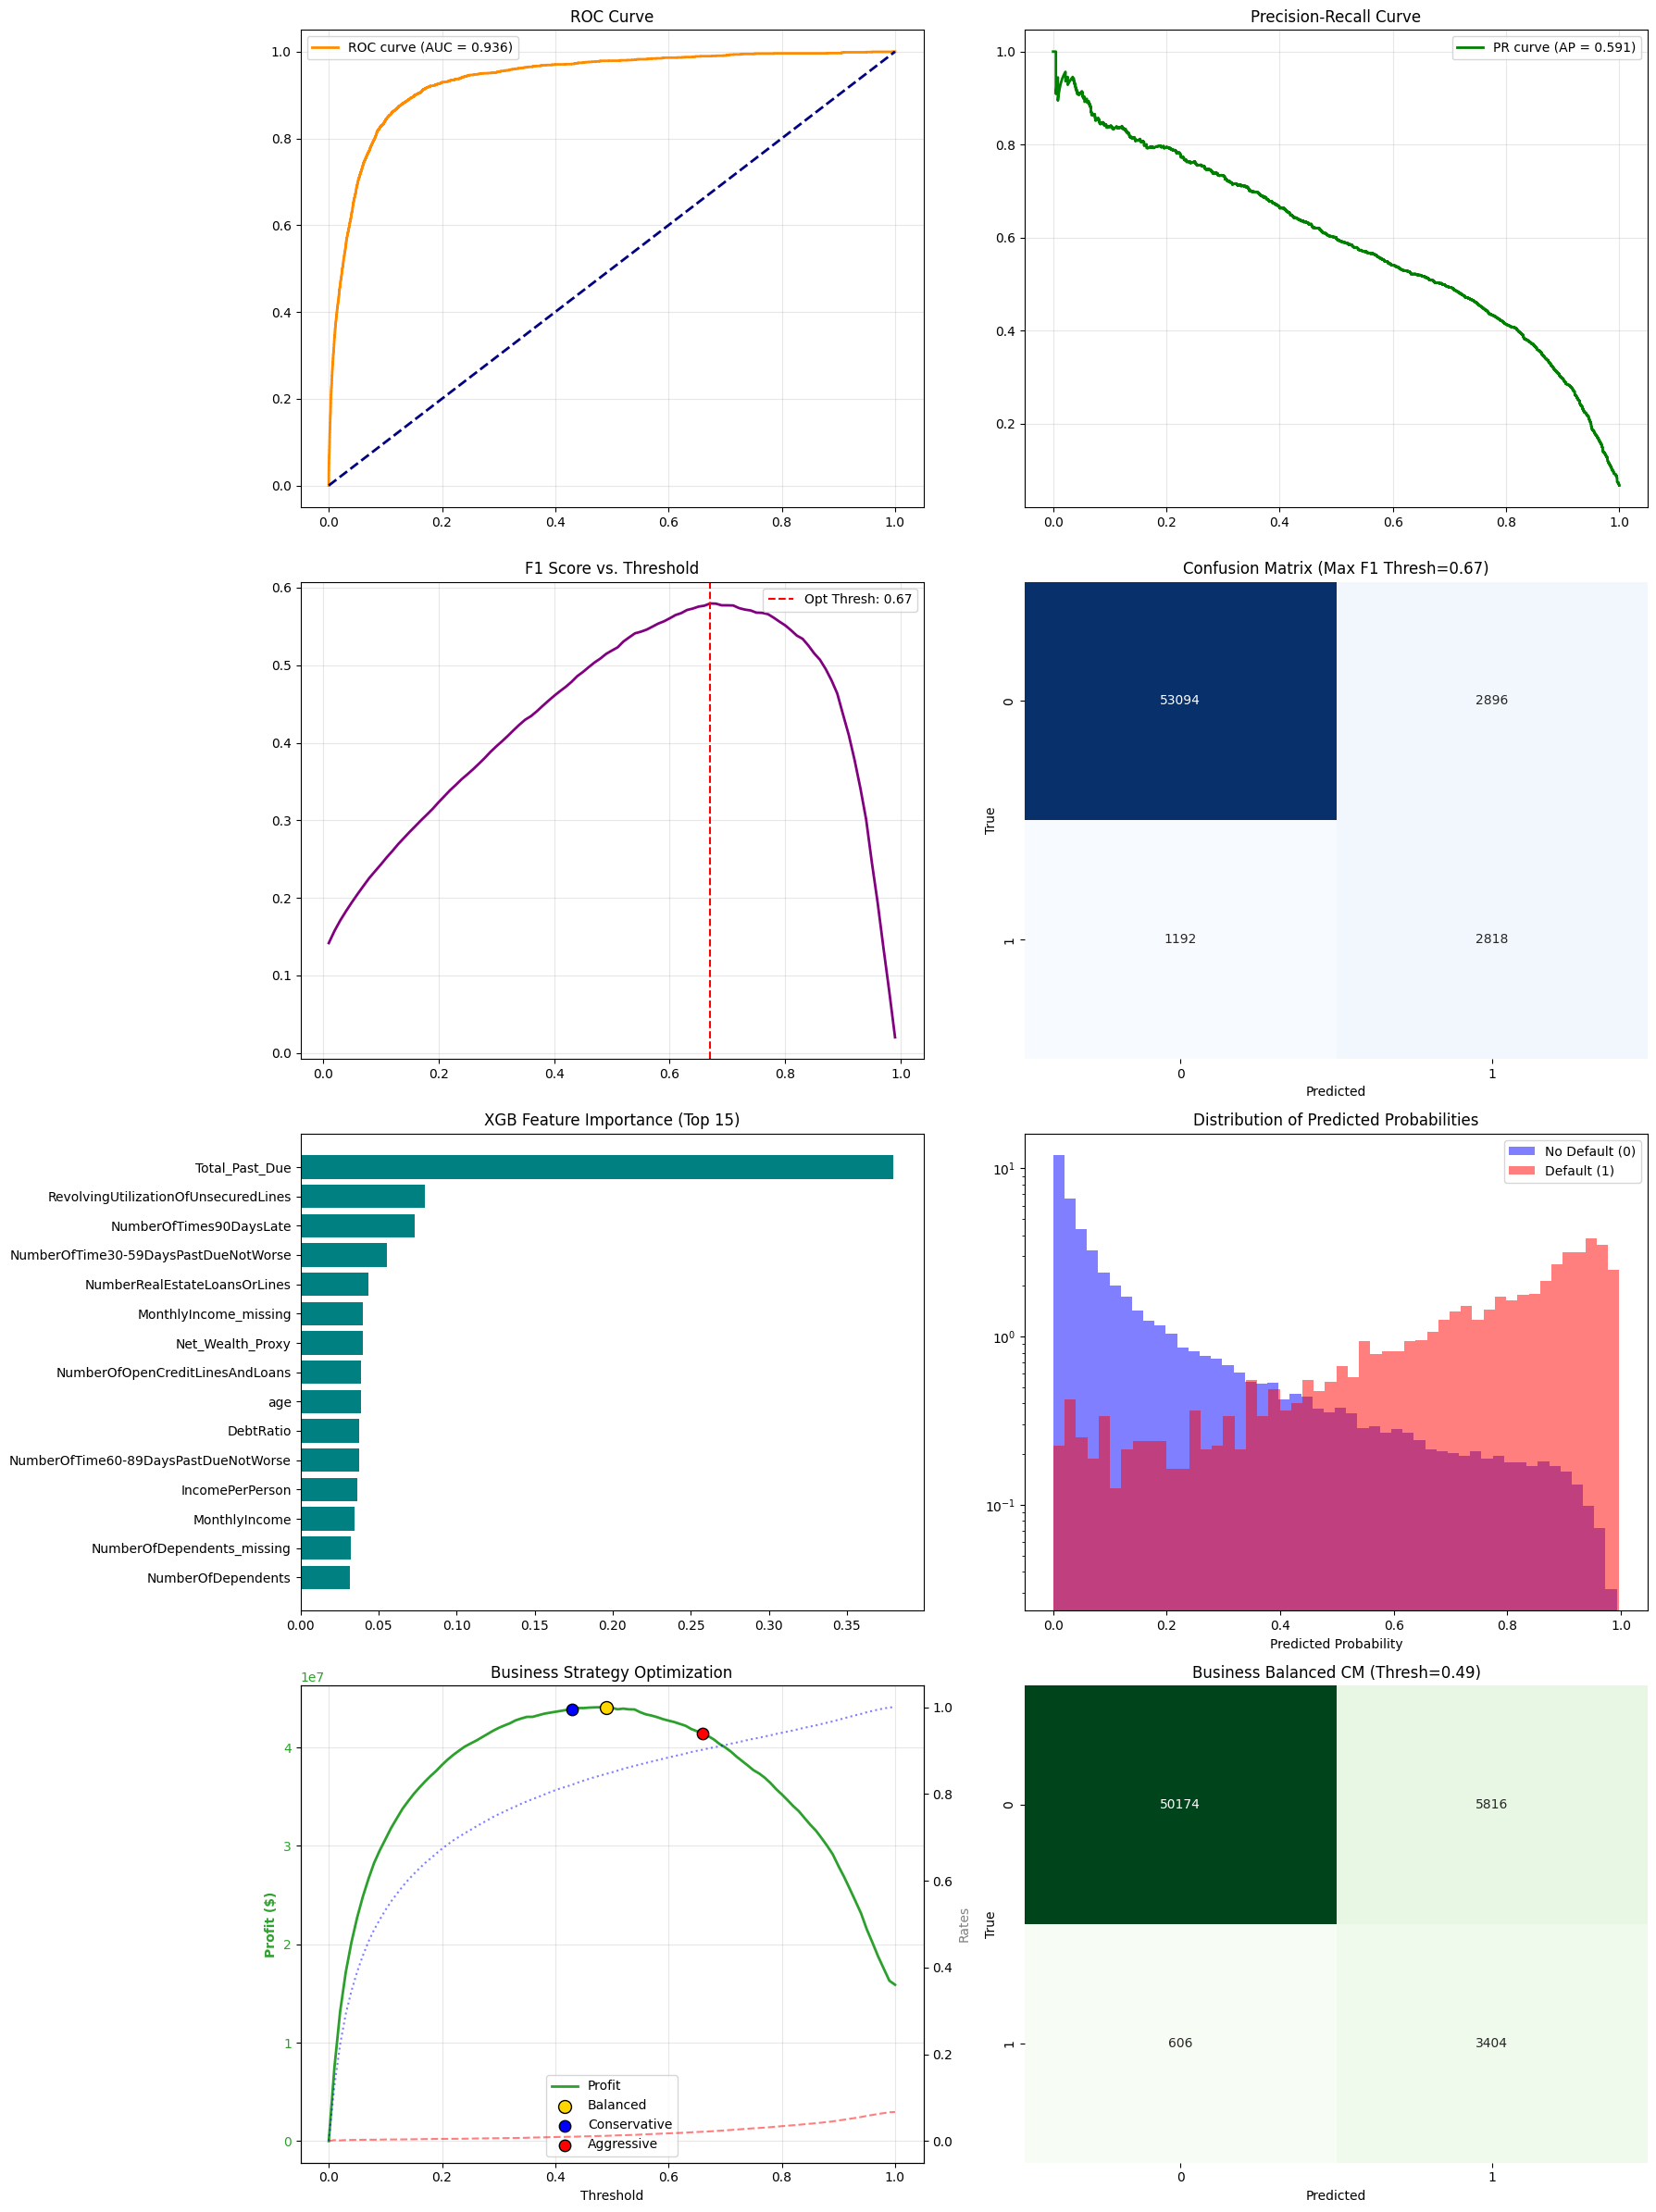

FINAL MODEL RESULTS (TECHNICAL)
Optimal Threshold (F1): 0.6700
Max F1 Score: 0.5796
ROC-AUC Score: 0.9363
PR-AUC Score: 0.5906
Brier Score: 0.0784

Classification Report (at F1 optimal threshold):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     55990
           1       0.49      0.70      0.58      4010

    accuracy                           0.93     60000
   macro avg       0.74      0.83      0.77     60000
weighted avg       0.95      0.93      0.94     60000


OPTIMIZED BUSINESS STRATEGIES
STRATEGY        | THRESH   | PROFIT       | RISK       | SCALE     
-----------------------------------------------------------------
Balanced        | 0.49     | $44,114,000   | 1.19%     | 84.63%
Conservative    | 0.43     | $43,926,000   | 0.99%     | 82.14%
Aggressive      | 0.66     | $41,412,000   | 2.13%     | 90.18%


In [0]:

# ==========================================
# 4. VISUALIZATIONS (4 Rows)
# ==========================================

# Increased height to fit 4 rows
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
plt.subplots_adjust(hspace=0.4)

# --- Row 1: ROC & PR ---
fpr, tpr, _ = roc_curve(y_test, xgb_pred_proba)
xgb_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {xgb_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, xgb_pred_proba)
xgb_pr_auc = average_precision_score(y_test, xgb_pred_proba)
axes[0, 1].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {xgb_pr_auc:.3f})')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- Row 2: F1 Threshold & Technical Confusion Matrix ---
axes[1, 0].plot(thresholds, f1_scores, color='purple', lw=2)
axes[1, 0].axvline(xgb_optimal_threshold, color='red', linestyle='--', label=f'Opt Thresh: {xgb_optimal_threshold:.2f}')
axes[1, 0].set_title('F1 Score vs. Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test, xgb_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title(f'Confusion Matrix (Max F1 Thresh={xgb_optimal_threshold:.2f})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# --- Row 3: Feature Importance & Probability Dist (RESTORED) ---
importances = xgb_best_model.feature_importances_
indices = np.argsort(importances)[::-1][:15] # Top 15
axes[2, 0].barh(range(len(indices)), importances[indices], align='center', color='teal')
axes[2, 0].set_yticks(range(len(indices)))
axes[2, 0].set_yticklabels([X_train_tree.columns[i] for i in indices])
axes[2, 0].invert_yaxis()
axes[2, 0].set_title('XGB Feature Importance (Top 15)')

# Probability Distribution (RESTORED)
prob_default = xgb_pred_proba[y_test == 1]
prob_no_default = xgb_pred_proba[y_test == 0]
axes[2, 1].hist(prob_no_default, bins=50, alpha=0.5, label='No Default (0)', color='blue', density=True)
axes[2, 1].hist(prob_default, bins=50, alpha=0.5, label='Default (1)', color='red', density=True)
axes[2, 1].set_xlabel('Predicted Probability')
axes[2, 1].set_yscale('log')
axes[2, 1].set_title('Distribution of Predicted Probabilities')
axes[2, 1].legend()

# --- Row 4: Business Strategy (ADDED) ---
ax_biz = axes[3, 0]
color = 'tab:green'
ax_biz.set_xlabel('Threshold')
ax_biz.set_ylabel('Profit ($)', color=color, fontweight='bold')
ax_biz.plot(xgb_arrays['thresholds'], xgb_arrays['profits'], color=color, lw=2, label='Profit')
ax_biz.tick_params(axis='y', labelcolor=color)
ax_biz.grid(True, alpha=0.3)

# Add Business Strategy Points
ax_biz.scatter(xgb_strat['Balanced']['Thresh'], xgb_strat['Balanced']['Profit'], color='gold', s=100, edgecolors='black', zorder=5, label='Balanced')
ax_biz.scatter(xgb_strat['Conservative']['Thresh'], xgb_strat['Conservative']['Profit'], color='blue', s=80, edgecolors='black', zorder=5, label='Conservative')
ax_biz.scatter(xgb_strat['Aggressive']['Thresh'], xgb_strat['Aggressive']['Profit'], color='red', s=80, edgecolors='black', zorder=5, label='Aggressive')

# Secondary Axis for Risk/Scale
ax_biz2 = ax_biz.twinx()
ax_biz2.plot(xgb_arrays['thresholds'], xgb_arrays['def_rates'], color='red', linestyle='--', alpha=0.5, label='Risk')
ax_biz2.plot(xgb_arrays['thresholds'], xgb_arrays['appr_rates'], color='blue', linestyle=':', alpha=0.5, label='Scale')
ax_biz2.set_ylabel('Rates', color='gray')
ax_biz.legend(loc='lower center')
ax_biz.set_title("Business Strategy Optimization")

# Business Confusion Matrix (Comparing Balanced approach)
bal_thresh = xgb_strat['Balanced']['Thresh']
y_pred_bal = (xgb_pred_proba >= bal_thresh).astype(int)
cm_biz = confusion_matrix(y_test, y_pred_bal)
sns.heatmap(cm_biz, annot=True, fmt='d', cmap='Greens', ax=axes[3, 1], cbar=False)
axes[3, 1].set_title(f'Business Balanced CM (Thresh={bal_thresh:.2f})')
axes[3, 1].set_xlabel('Predicted')
axes[3, 1].set_ylabel('True')

plt.tight_layout()
plt.show()

# ==========================================
# 5. FINAL REPORTS (RESTORED BOTH)
# ==========================================

print("="*50)
print("FINAL MODEL RESULTS (TECHNICAL)")
print("="*50)
print(f"Optimal Threshold (F1): {xgb_optimal_threshold:.4f}")
print(f"Max F1 Score: {xgb_max_f1:.4f}")
print(f"ROC-AUC Score: {xgb_auc:.4f}")
print(f"PR-AUC Score: {xgb_pr_auc:.4f}")
print(f"Brier Score: {brier_score_loss(y_test, xgb_pred_proba):.4f}")
print("\nClassification Report (at F1 optimal threshold):")
print(classification_report(y_test, xgb_pred_optimal))

print("\n" + "="*50)
print("OPTIMIZED BUSINESS STRATEGIES")
print("="*50)
print(f"{'STRATEGY':<15} | {'THRESH':<8} | {'PROFIT':<12} | {'RISK':<10} | {'SCALE':<10}")
print("-" * 65)
for name, data in xgb_strat.items():
    print(f"{name:<15} | {data['Thresh']:.2f}     | ${data['Profit']:,.0f}   | {data['Risk']:.2%}     | {data['Scale']:.2%}")

The model catches about 70% of all defaults (Recall = 0.70) while maintaining a 49% precision (Precision = 0.49). This means when the model says "Default", it's right about half the time.  
Total_Past_Due is by far the most critical predictor.  
Probability Distribution:  
Blue (Non-Defaulters): Massively clustered near 0.0. The model is very confident they are safe.  
Red (Defaulters): While spread out, they shift significantly towards the right (higher probability).

## Logistic

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score, brier_score_loss
import joblib   
import os
from sklearn.metrics import roc_auc_score
# =============================================================
# 1) TRAINING — LOGISTIC REGRESSION (CALIBRATED + TUNED)
# =============================================================

LOGREG_MODEL_PATH = "logreg_final_model.joblib"

# We must scale first (pipeline B)
X_train_scaled, X_test_scaled = build_pipeline_B(X_train, X_test)

if os.path.exists(LOGREG_MODEL_PATH):
    print("Loading cached Calibrated Logistic Regression model...")
    logreg_model = joblib.load(LOGREG_MODEL_PATH)

    # Compute training AUC for reporting
    train_proba = logreg_model.predict_proba(X_train_scaled)[:, 1]
    train_auc = roc_auc_score(y_train, train_proba)

    print("\n===== LOGISTIC REGRESSION SUMMARY (CACHED MODEL) =====")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Model: Calibrated LogReg (sigmoid)")
    print(f"Loaded from: {LOGREG_MODEL_PATH}")
    print("=======================================================\n")

else:
    print("Training CALIBRATED Logistic Regression model...")

    # ---- BASE LOGISTIC MODEL (your tuned version) ----
    base_logreg = LogisticRegression(
        max_iter=3000,
        solver='lbfgs',
        class_weight='balanced'
    )

    # ---- Probability Calibration (Sigmoid / Platt scaling) ----
    logreg_model = CalibratedClassifierCV(base_logreg, cv=3, method='sigmoid')
    logreg_model.fit(X_train_scaled, y_train)

    # Training AUC
    train_proba = logreg_model.predict_proba(X_train_scaled)[:, 1]
    train_auc = roc_auc_score(y_train, train_proba)

    # Save model
    joblib.dump(logreg_model, LOGREG_MODEL_PATH)

    print("\n===== LOGISTIC REGRESSION TRAINING SUMMARY =====")
    print(f"Training AUC: {train_auc:.4f}")
    print("Model: Calibrated Logistic Regression (sigmoid)")
    print(f"Saved model to: {LOGREG_MODEL_PATH}")
    print("=================================================\n")


Training CALIBRATED Logistic Regression model...

===== LOGISTIC REGRESSION TRAINING SUMMARY =====
Training AUC: 0.8554
Model: Calibrated Logistic Regression (sigmoid)
Saved model to: logreg_final_model.joblib



In [0]:
# -------------------------------------------------
# 2. PREDICT PROBABILITIES (CACHED)
# -------------------------------------------------

LOGREG_PROBA_PATH = "logreg_pred_proba.joblib"

if os.path.exists(LOGREG_PROBA_PATH):
    print("Loading cached Logistic probabilities...")
    logreg_pred_proba = joblib.load(LOGREG_PROBA_PATH)

else:
    print("Generating Logistic predicted probabilities...")
    logreg_pred_proba = logreg_model.predict_proba(X_test_scaled)[:, 1]
    joblib.dump(logreg_pred_proba, LOGREG_PROBA_PATH)
    print(f"Saved probabilities to {LOGREG_PROBA_PATH}")


Generating Logistic predicted probabilities...
Saved probabilities to logreg_pred_proba.joblib


In [0]:
# -------------------------------------------------
# 3. THRESHOLD OPTIMIZATION + BUSINESS METRICS
# -------------------------------------------------

thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_temp = (logreg_pred_proba >= t).astype(int)
    tp = np.sum((y_test == 1) & (y_temp == 1))
    fp = np.sum((y_test == 0) & (y_temp == 1))
    fn = np.sum((y_test == 1) & (y_temp == 0))

    precision_t = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision_t * recall_t / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
logreg_optimal_threshold = thresholds[max_f1_idx]
logreg_max_f1 = f1_scores[max_f1_idx]
logreg_pred_optimal = (logreg_pred_proba >= logreg_optimal_threshold).astype(int)

# Business metrics
logreg_biz = get_business_metrics(y_test, logreg_pred_proba)
logreg_strat = logreg_biz['strategies']
logreg_arrays = logreg_biz['arrays']

LOGISTIC REGRESSION — FINAL RESULTS
Optimal Threshold (F1): 0.1600
Max F1 Score:          0.4142
ROC-AUC Score:         0.8493
PR-AUC Score:          0.3494
Brier Score:           0.0520

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     55990
           1       0.36      0.49      0.41      4010

    accuracy                           0.91     60000
   macro avg       0.66      0.71      0.68     60000
weighted avg       0.92      0.91      0.91     60000


BUSINESS STRATEGY RESULTS
Balanced     | Thresh=0.090 | Profit=$34,498,000 | Risk=2.54% | Scale=79.73%
Conservative | Thresh=0.020 | Profit=$21,796,000 | Risk=0.90% | Scale=40.30%
Aggressive   | Thresh=0.150 | Profit=$32,588,000 | Risk=3.61% | Scale=90.10%

Saved: logreg_predictions.csv


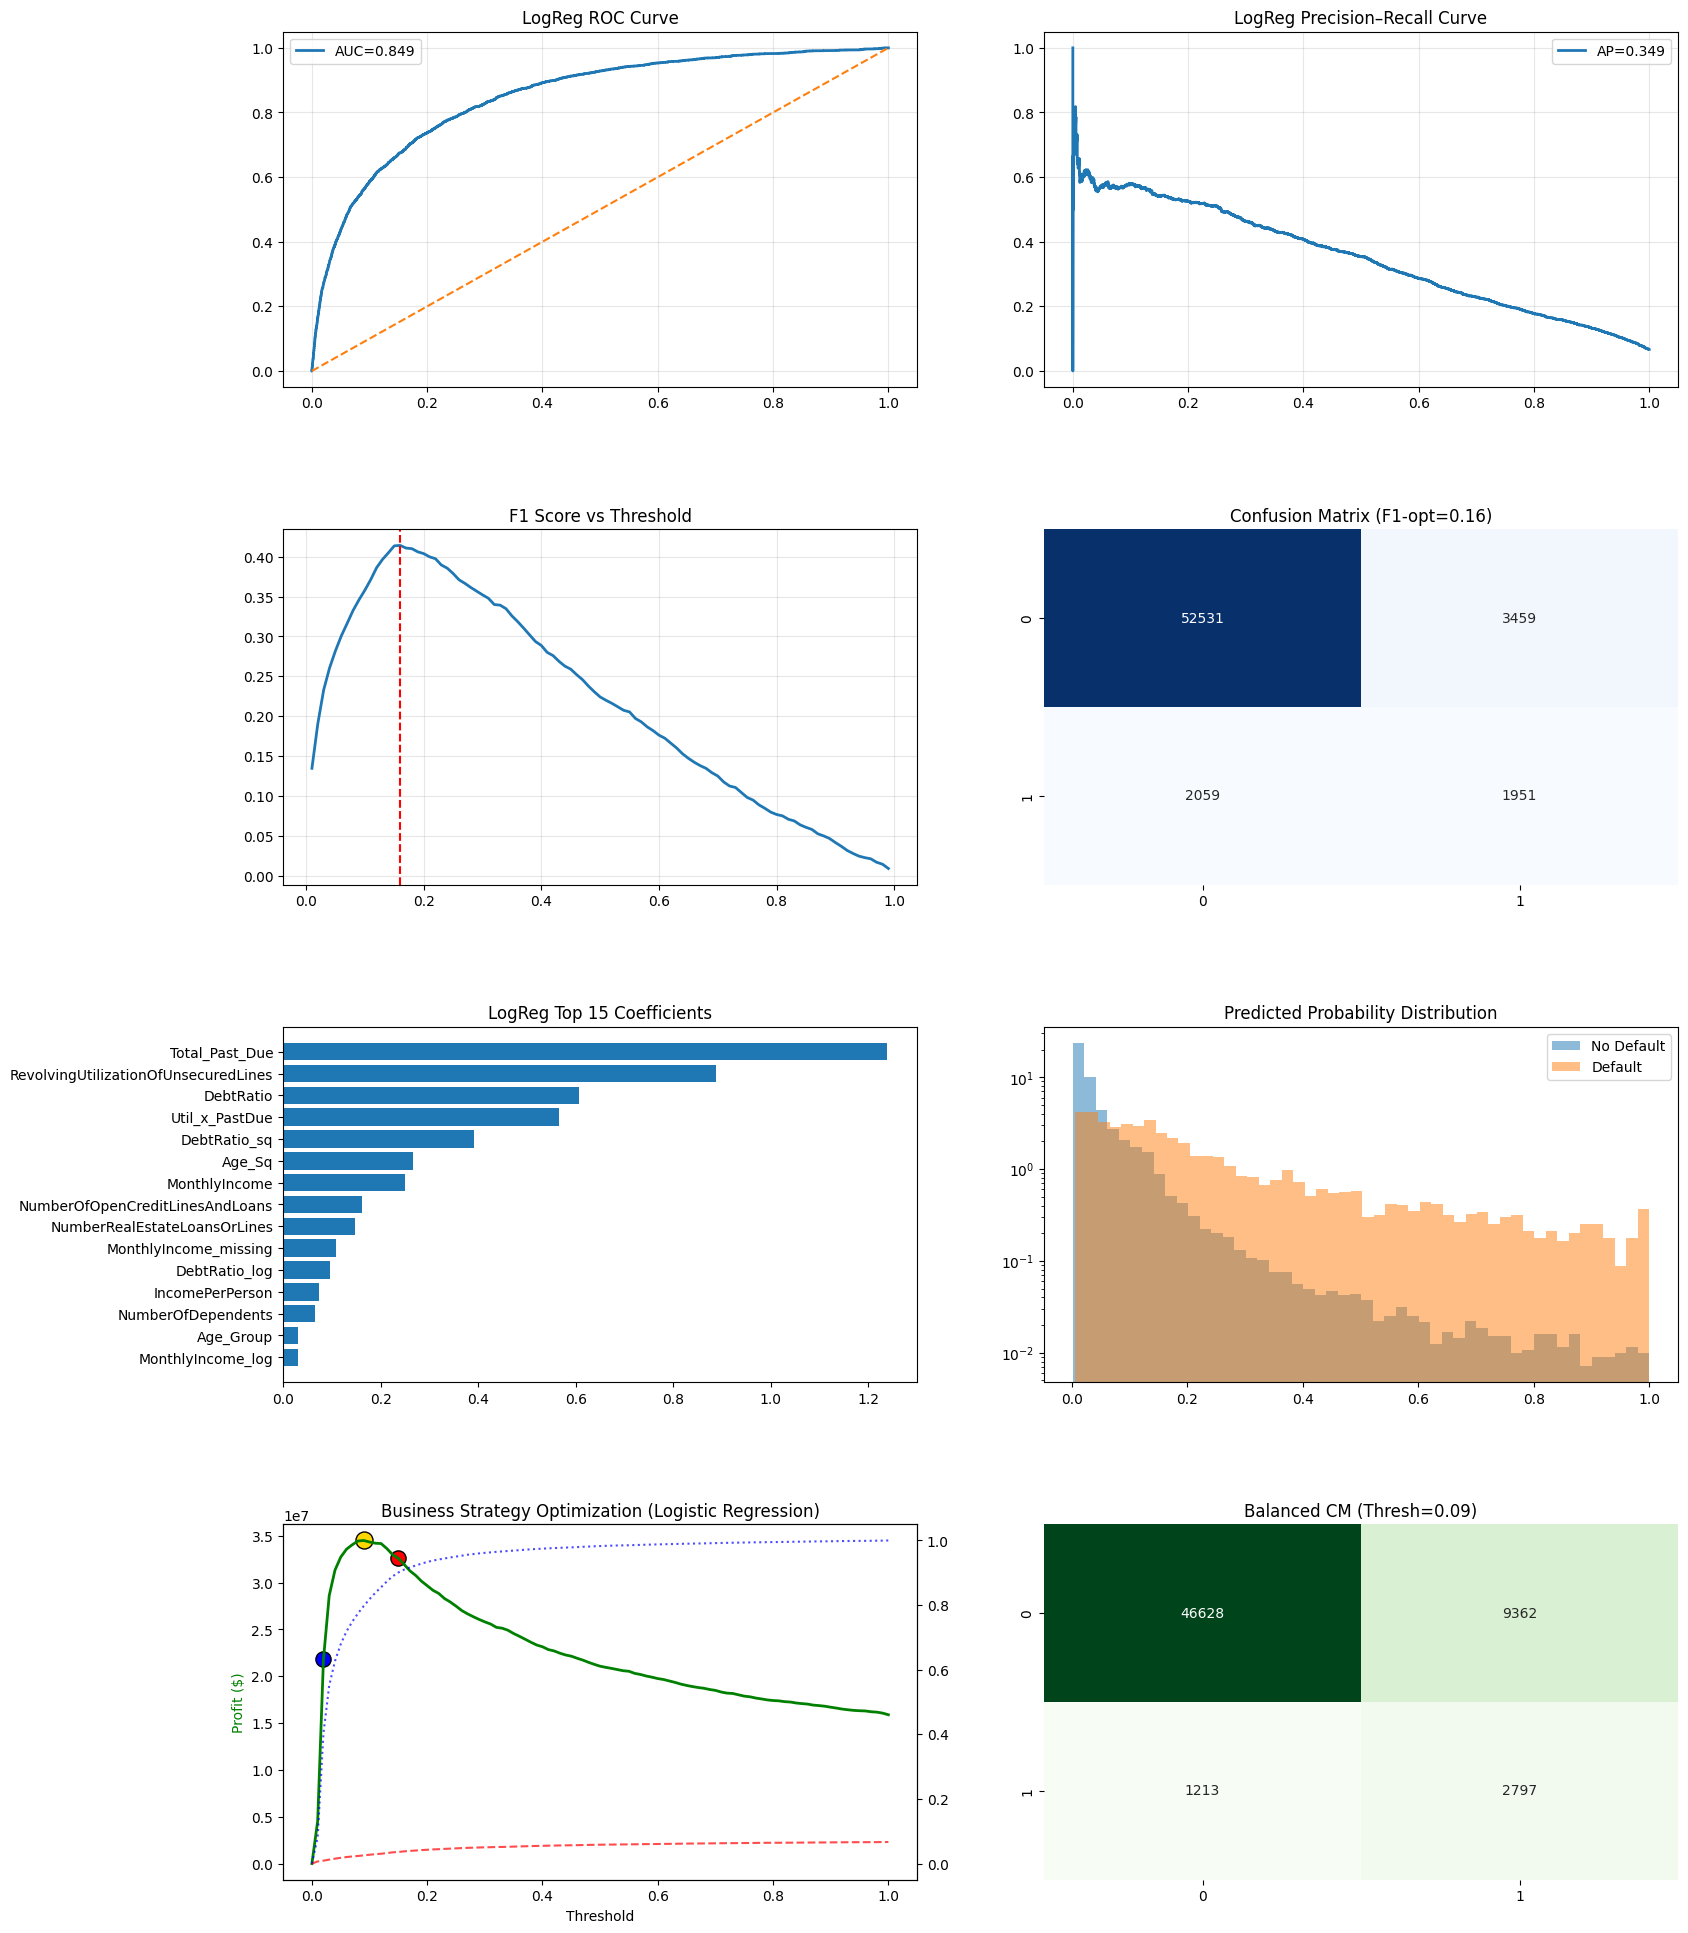

In [0]:
# -------------------------------------------------
# 4. VISUALIZATIONS (same layout as XGBoost)
# -------------------------------------------------
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
    f1_score,
    brier_score_loss
)

# -------------------------------------------------
# Helper: Extract coefficients safely
# -------------------------------------------------
def extract_logreg_coef(model):
    """
    Extracts logistic regression coefficients from:
    - LogisticRegression
    - CalibratedClassifierCV wrapping LogisticRegression
    Works for all sklearn versions.
    """
    # Case 1 : plain logistic regression
    if hasattr(model, "coef_"):
        return model.coef_[0]

    # Case 2 : calibrated logistic (after fitting)
    if hasattr(model, "calibrated_classifiers_"):
        est = model.calibrated_classifiers_[0].estimator
        if hasattr(est, "coef_"):
            return est.coef_[0]

    # Case 3 : calibrated logistic (before fitting)
    if hasattr(model, "base_estimator"):
        base = model.base_estimator
        if hasattr(base, "coef_"):
            return base.coef_[0]

    raise ValueError("Model has no accessible logistic regression coefficients.")


# -------------------------------------------------
# 4. VISUALIZATION PANELS
# -------------------------------------------------

fig, axes = plt.subplots(4, 2, figsize=(18, 24))
plt.subplots_adjust(hspace=0.4)

# ---------------- ROW 1 : ROC + PR ----------------
fpr, tpr, _ = roc_curve(y_test, logreg_pred_proba)
logreg_auc = roc_auc_score(y_test, logreg_pred_proba)

axes[0, 0].plot(fpr, tpr, lw=2, label=f"AUC={logreg_auc:.3f}")
axes[0, 0].plot([0,1],[0,1],'--')
axes[0, 0].set_title("LogReg ROC Curve")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, logreg_pred_proba)
logreg_pr_auc = average_precision_score(y_test, logreg_pred_proba)

axes[0, 1].plot(recall, precision, lw=2, label=f"AP={logreg_pr_auc:.3f}")
axes[0, 1].set_title("LogReg Precision–Recall Curve")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ---------------- ROW 2 : F1 + CM ----------------
axes[1, 0].plot(thresholds, f1_scores, lw=2)
axes[1, 0].axvline(logreg_optimal_threshold, color='red', linestyle='--')
axes[1, 0].set_title("F1 Score vs Threshold")
axes[1, 0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test, logreg_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title(f"Confusion Matrix (F1-opt={logreg_optimal_threshold:.2f})")

# ---------------- ROW 3 : COEFFICIENTS + PROBABILITY DIST ----------------
coef_vals = extract_logreg_coef(logreg_model)

# Ensure correct length
coef_vals = coef_vals[:len(X_train_scaled.columns)]
coef = pd.Series(coef_vals, index=X_train_scaled.columns).abs().sort_values(ascending=False)

axes[2, 0].barh(coef.index[:15], coef.values[:15])
axes[2, 0].invert_yaxis()
axes[2, 0].set_title("LogReg Top 15 Coefficients")

prob_default = logreg_pred_proba[y_test==1]
prob_no_default = logreg_pred_proba[y_test==0]

axes[2, 1].hist(prob_no_default, bins=50, alpha=.5, label='No Default', density=True)
axes[2, 1].hist(prob_default, bins=50, alpha=.5, label='Default', density=True)
axes[2, 1].set_yscale('log')
axes[2, 1].set_title("Predicted Probability Distribution")
axes[2, 1].legend()

# ---------------- ROW 4 : BUSINESS OPT + CM ----------------
ax = axes[3, 0]
ax.plot(logreg_arrays['thresholds'], logreg_arrays['profits'], lw=2, color='green', label="Profit")

ax2 = ax.twinx()
ax2.plot(logreg_arrays['thresholds'], logreg_arrays['def_rates'], '--', color='red', alpha=.7, label="Risk")
ax2.plot(logreg_arrays['thresholds'], logreg_arrays['appr_rates'], ':', color='blue', alpha=.7, label="Approval Rate")

# Strategy markers
bal = logreg_strat["Balanced"]
con = logreg_strat["Conservative"]
agg = logreg_strat["Aggressive"]

ax.scatter(bal["Thresh"], bal["Profit"], s=150, c='gold', edgecolor='black')
ax.scatter(con["Thresh"], con["Profit"], s=120, c='blue', edgecolor='black')
ax.scatter(agg["Thresh"], agg["Profit"], s=120, c='red', edgecolor='black')

ax.set_title("Business Strategy Optimization (Logistic Regression)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Profit ($)", color='green')

bal_t = bal["Thresh"]
y_pred_bal = (logreg_pred_proba >= bal_t).astype(int)

cm_biz = confusion_matrix(y_test, y_pred_bal)
sns.heatmap(cm_biz, annot=True, fmt='d', cmap='Greens', ax=axes[3, 1], cbar=False)
axes[3, 1].set_title(f"Balanced CM (Thresh={bal_t:.2f})")
print("="*50)
print("LOGISTIC REGRESSION — FINAL RESULTS")
print("="*50)
print(f"Optimal Threshold (F1): {logreg_optimal_threshold:.4f}")
print(f"Max F1 Score:          {logreg_max_f1:.4f}")
print(f"ROC-AUC Score:         {logreg_auc:.4f}")
print(f"PR-AUC Score:          {logreg_pr_auc:.4f}")
print(f"Brier Score:           {brier_score_loss(y_test, logreg_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, logreg_pred_optimal))

print("\n" + "="*50)
print("BUSINESS STRATEGY RESULTS")
print("="*50)
for name, d in logreg_strat.items():
    print(f"{name:12} | Thresh={d['Thresh']:.3f} | Profit=${d['Profit']:,.0f} | "
          f"Risk={d['Risk']:.2%} | Scale={d['Scale']:.2%}")

# Save predictions
logreg_results_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_F1opt": logreg_pred_optimal,
    "y_prob": logreg_pred_proba
})
logreg_results_df.to_csv("logreg_predictions.csv", index=False)
print("\nSaved: logreg_predictions.csv")


## NN model

In [0]:
!pip install tensorflow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# ===========================================
# 1. NEURAL NETWORK TRAINING (CACHED + PROGRESS BAR + SUMMARY OUTPUT)
# ===========================================

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_auc_score
import os, joblib
import numpy as np

NN_MODEL_PATH = "nn_final_model.keras"

print("\n============================")
print("Neural Network Pipeline (B2)")
print("============================")

if os.path.exists(NN_MODEL_PATH):
    print("Loading cached NN model (no re-training)...")
    nn_model = tf.keras.models.load_model(NN_MODEL_PATH)

else:
    print("No cached NN model — training Neural Network (first time)...")

    input_dim = X_train_nn.shape[1]

    # -----------------------------
    # Improved NN Architecture (keeps your structure but more stable)
    # -----------------------------
    nn_model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['AUC']
    )

    # -----------------------------
    # Progress bar for epochs
    # -----------------------------
    EPOCHS = 25
    BATCH_SIZE = 1024

    class TQDMCallback(tf.keras.callbacks.Callback):
        def __init__(self, epochs):
            self.epochs = epochs
            self.pbar = tqdm(total=epochs, desc="NN Training Progress")

        def on_epoch_end(self, epoch, logs=None):
            self.pbar.update(1)

        def on_train_end(self, logs=None):
            self.pbar.close()

    tqdm_callback = TQDMCallback(EPOCHS)

    # -----------------------------
    # Train model with validation split
    # -----------------------------
    history = nn_model.fit(
        X_train_nn,
        y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[tqdm_callback]
    )

    # -----------------------------
    # Save trained model
    # -----------------------------
    nn_model.save(NN_MODEL_PATH)
    print(f"NN model saved to: {NN_MODEL_PATH}")

    # -----------------------------
    # Compute training AUC (IMPORTANT: must use X_train_nn!)
    # -----------------------------
    nn_train_proba = nn_model.predict(X_train_nn, verbose=0).ravel()
    nn_train_auc = roc_auc_score(y_train, nn_train_proba)

    # -----------------------------
    # XGBoost-style Summary Output
    # -----------------------------
    print("\n===== NEURAL NETWORK TRAINING SUMMARY =====")
    print(f"NN Train AUC: {nn_train_auc:.4f}")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
    print(f"Model saved to: {NN_MODEL_PATH}")
    print("===========================================\n")


Neural Network Pipeline (B2)
No cached NN model — training Neural Network (first time)...


/local_disk0/.ephemeral_nfs/envs/pythonEnv-86a1f022-a947-4073-8a60-b4b24d93bfa1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
NN Training Progress: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


NN model saved to: nn_final_model.keras

===== NEURAL NETWORK TRAINING SUMMARY =====
NN Train AUC: 0.8689
Epochs: 25, Batch size: 1024
Model saved to: nn_final_model.keras



In [0]:
# -------------------------------------------------
# 2. PREDICT PROBABILITIES (CACHED)
# -------------------------------------------------

NN_PROBA_PATH = "nn_pred_proba.joblib"

if os.path.exists(NN_PROBA_PATH):
    print("Loading cached NN probabilities...")
    nn_pred_proba = joblib.load(NN_PROBA_PATH)

else:
    print("Generating NN predicted probabilities...")
    nn_pred_proba = nn_model.predict(X_test_nn, verbose=0).flatten()

    joblib.dump(nn_pred_proba, NN_PROBA_PATH)
    print(f"Saved NN probabilities to: {NN_PROBA_PATH}")

Generating NN predicted probabilities...
Saved NN probabilities to: nn_pred_proba.joblib


In [0]:
# -------------------------------------------------
# 3. THRESHOLD OPTIMIZATION + BUSINESS METRICS
# -------------------------------------------------

thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_temp = (nn_pred_proba >= t).astype(int)
    tp = np.sum((y_test == 1) & (y_temp == 1))
    fp = np.sum((y_test == 0) & (y_temp == 1))
    fn = np.sum((y_test == 1) & (y_temp == 0))

    precision_t = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision_t * recall_t / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
nn_optimal_threshold = thresholds[max_f1_idx]
nn_max_f1 = f1_scores[max_f1_idx]
nn_pred_optimal = (nn_pred_proba >= nn_optimal_threshold).astype(int)

# Business metrics
nn_biz = get_business_metrics(y_test, nn_pred_proba)
nn_strat = nn_biz['strategies']
nn_arrays = nn_biz['arrays']


NEURAL NETWORK — FINAL RESULTS
Optimal Threshold (F1): 0.1900
Max F1 Score:          0.4319
ROC-AUC Score:         0.8596
PR-AUC Score:          0.3855
Brier Score:           0.0498

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     55990
           1       0.38      0.50      0.43      4010

    accuracy                           0.91     60000
   macro avg       0.67      0.72      0.69     60000
weighted avg       0.92      0.91      0.92     60000


BUSINESS STRATEGY RESULTS
Balanced     | Thresh=0.100 | Profit=$35,472,000 | Risk=2.75% | Scale=84.79%
Conservative | Thresh=0.010 | Profit=$15,703,000 | Risk=0.60% | Scale=28.02%
Aggressive   | Thresh=0.170 | Profit=$33,396,000 | Risk=3.48% | Scale=90.16%

Saved: nn_predictions.csv


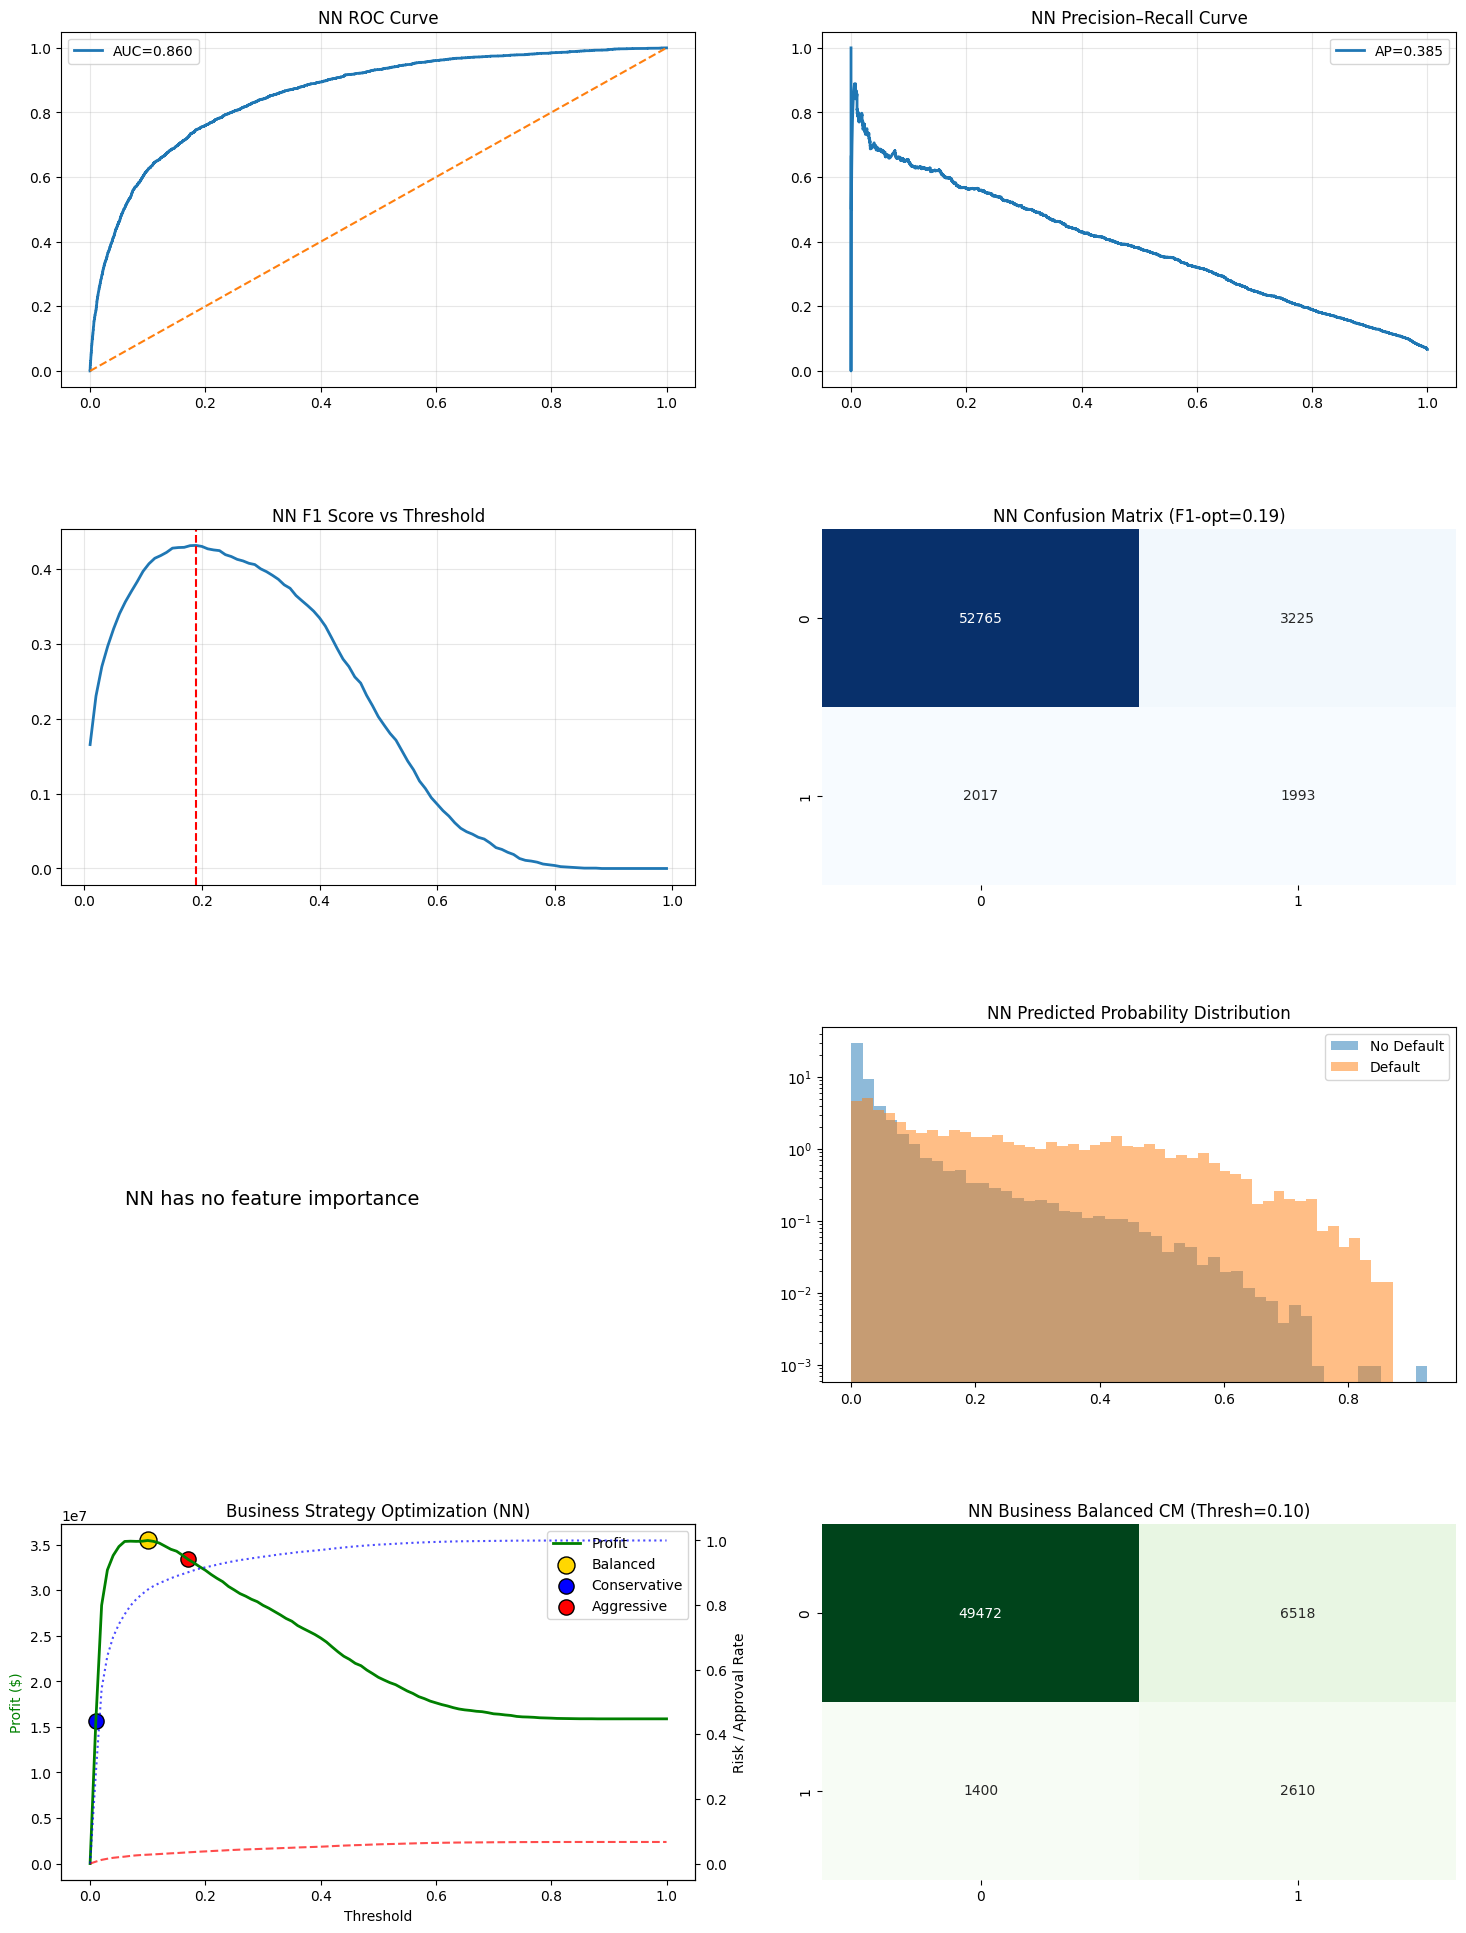

In [0]:
# -------------------------------------------------
# 4. VISUALIZATIONS (same layout as XGBoost)
# -------------------------------------------------

fig, axes = plt.subplots(4, 2, figsize=(18, 24))
plt.subplots_adjust(hspace=0.4)

# --- Row 1: ROC & PR ---
fpr, tpr, _ = roc_curve(y_test, nn_pred_proba)
nn_auc = roc_auc_score(y_test, nn_pred_proba)

axes[0, 0].plot(fpr, tpr, lw=2, label=f"AUC={nn_auc:.3f}")
axes[0, 0].plot([0,1],[0,1],'--')
axes[0, 0].set_title("NN ROC Curve")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, nn_pred_proba)
nn_pr_auc = average_precision_score(y_test, nn_pred_proba)
axes[0, 1].plot(recall, precision, lw=2, label=f"AP={nn_pr_auc:.3f}")
axes[0, 1].set_title("NN Precision–Recall Curve")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- Row 2: F1 Threshold & Technical Confusion Matrix ---
axes[1, 0].plot(thresholds, f1_scores, lw=2)
axes[1, 0].axvline(nn_optimal_threshold, color='red', linestyle='--')
axes[1, 0].set_title("NN F1 Score vs Threshold")
axes[1, 0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test, nn_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title(f"NN Confusion Matrix (F1-opt={nn_optimal_threshold:.2f})")

# --- Row 3: Probability Distribution ---
prob_default = nn_pred_proba[y_test==1]
prob_no_default = nn_pred_proba[y_test==0]
axes[2, 1].hist(prob_no_default, bins=50, alpha=.5, label='No Default', density=True)
axes[2, 1].hist(prob_default, bins=50, alpha=.5, label='Default', density=True)
axes[2, 1].set_yscale('log')
axes[2, 1].set_title("NN Predicted Probability Distribution")
axes[2, 1].legend()

# Dummy feature importance (NN has no native FI)
axes[2, 0].text(0.1, 0.5, "NN has no feature importance", fontsize=14)
axes[2, 0].axis('off')

# --- Row 4: Business Strategy Optimization (XGBoost-style) ---
ax = axes[3, 0]

# Profit curve
ax.plot(
    nn_arrays['thresholds'], 
    nn_arrays['profits'], 
    color='green', lw=2, label="Profit"
)

# Risk curve
ax2 = ax.twinx()
ax2.plot(
    nn_arrays['thresholds'],
    nn_arrays['def_rates'],
    color='red',
    linestyle='--',
    alpha=0.7,
    label="Risk"
)

# Approval rate curve
ax2.plot(
    nn_arrays['thresholds'],
    nn_arrays['appr_rates'],
    color='blue',
    linestyle=':',
    alpha=0.7,
    label="Approval Rate"
)

# ----------------------------
#   Strategy markers
# ----------------------------
# Balanced Strategy
bal_t = nn_strat["Balanced"]["Thresh"]
ax.scatter(bal_t,
           nn_strat["Balanced"]["Profit"],
           s=150, c='gold', edgecolor='black', label="Balanced")

# Conservative Strategy
cons_t = nn_strat["Conservative"]["Thresh"]
ax.scatter(cons_t,
           nn_strat["Conservative"]["Profit"],
           s=120, c='blue', edgecolor='black', label="Conservative")

# Aggressive Strategy
agg_t = nn_strat["Aggressive"]["Thresh"]
ax.scatter(agg_t,
           nn_strat["Aggressive"]["Profit"],
           s=120, c='red', edgecolor='black', label="Aggressive")


# ----------------------------
#  LABELS / TITLE / LEGEND
# ----------------------------
ax.set_xlabel("Threshold")
ax.set_ylabel("Profit ($)", color='green')
ax2.set_ylabel("Risk / Approval Rate", color='black')
ax.set_title("Business Strategy Optimization (NN)", fontsize=12)

# Combine legends from both y-axes
lns = ax.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]

# Add strategy labels too
ax.legend(loc="upper right", fontsize=10)

# ----------------------------
# Business Confusion Matrix
# ----------------------------
y_pred_bal = (nn_pred_proba >= bal_t).astype(int)
cm_biz = confusion_matrix(y_test, y_pred_bal)
sns.heatmap(cm_biz, annot=True, fmt='d', cmap='Greens',
            ax=axes[3, 1], cbar=False)
axes[3, 1].set_title(f"NN Business Balanced CM (Thresh={bal_t:.2f})")



# -------------------------------------------------
# 5. FINAL REPORTS + SAVED PREDICTIONS
# -------------------------------------------------

print("="*50)
print("NEURAL NETWORK — FINAL RESULTS")
print("="*50)
print(f"Optimal Threshold (F1): {nn_optimal_threshold:.4f}")
print(f"Max F1 Score:          {nn_max_f1:.4f}")
print(f"ROC-AUC Score:         {nn_auc:.4f}")
print(f"PR-AUC Score:          {nn_pr_auc:.4f}")
print(f"Brier Score:           {brier_score_loss(y_test, nn_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nn_pred_optimal))

print("\n" + "="*50)
print("BUSINESS STRATEGY RESULTS")
print("="*50)
for name, d in nn_strat.items():
    print(f"{name:12} | Thresh={d['Thresh']:.3f} | Profit=${d['Profit']:,.0f} | "
          f"Risk={d['Risk']:.2%} | Scale={d['Scale']:.2%}")

# Save predictions
nn_results_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_F1opt": nn_pred_optimal,
    "y_prob": nn_pred_proba
})
nn_results_df.to_csv("nn_predictions.csv", index=False)
print("\nSaved: nn_predictions.csv")

# Model comparison

In [0]:
# ============================================================
# 0. LOAD ALL MODELS + DATA
# ============================================================

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, f1_score, roc_curve,
    precision_recall_curve, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------
# Load saved models
# ---------------------
logreg_model = joblib.load("logreg_final_model.joblib")
rf_best_model = joblib.load("rf_best_model.joblib")
dt_best_model = joblib.load("decision_tree_final_model.joblib")
xgb_model = joblib.load("xgb_best_model.joblib")
nn_pred_proba = joblib.load("nn_pred_proba.joblib")  # NN model already loaded separately

# ---------------------
# Load probabilities for models (cached earlier)
# ---------------------
logreg_pred_proba = joblib.load("logreg_pred_proba.joblib")
rf_pred_proba = joblib.load("rf_pred_proba.joblib")
dt_pred_proba = joblib.load("decision_tree_pred_proba.joblib")
xgb_pred_proba = joblib.load("xgb_pred_proba.joblib")

# NN already has probability from pipeline
# nn_pred_proba variable already exists

# ---------------------
# For training AUC (LOAD FROM TRAIN OR RECOMPUTE)
# ---------------------
logreg_train_proba = logreg_model.predict_proba(X_train_scaled)[:, 1]
rf_train_proba = rf_best_model.predict_proba(X_train_tree)[:, 1]
dt_train_proba = dt_best_model.predict_proba(X_train_tree)[:, 1]
xgb_train_proba = xgb_model.predict_proba(X_train_tree)[:, 1]
nn_train_proba = nn_model.predict(X_train_nn).ravel()

models = {
    "Logistic":   (logreg_train_proba, logreg_pred_proba),
    "RandomForest": (rf_train_proba, rf_pred_proba),
    "XGBoost":    (xgb_train_proba, xgb_pred_proba),
    "NeuralNet":  (nn_train_proba, nn_pred_proba),
    "DecisionTree": (dt_train_proba, dt_pred_proba)
}


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 6s 835us/step


In [0]:
# ============================================================
# 1. STABILITY COMPARISON TABLE
# ============================================================

records = []

for name, (train_p, test_p) in models.items():
    train_auc = roc_auc_score(y_train, train_p)
    test_auc  = roc_auc_score(y_test, test_p)
    gap = train_auc - test_auc
    
    interpretation = (
        "Very stable"        if gap < 0.02 else
        "Some overfitting"   if gap < 0.10 else
        "Unstable"           if gap < 0.20 else
        "Highly unstable"
    )
    
    records.append([name, train_auc, test_auc, gap, interpretation])

stability_df = pd.DataFrame(records, 
                             columns=["Model","Train AUC","Test AUC","Gap","Interpretation"])

print(stability_df)


          Model  Train AUC  Test AUC       Gap    Interpretation
0      Logistic   0.855394  0.849314  0.006080       Very stable
1  RandomForest   0.959765  0.918317  0.041449  Some overfitting
2       XGBoost   0.982132  0.936296  0.045836  Some overfitting
3     NeuralNet   0.868854  0.859587  0.009267       Very stable
4  DecisionTree   0.895304  0.867756  0.027548  Some overfitting


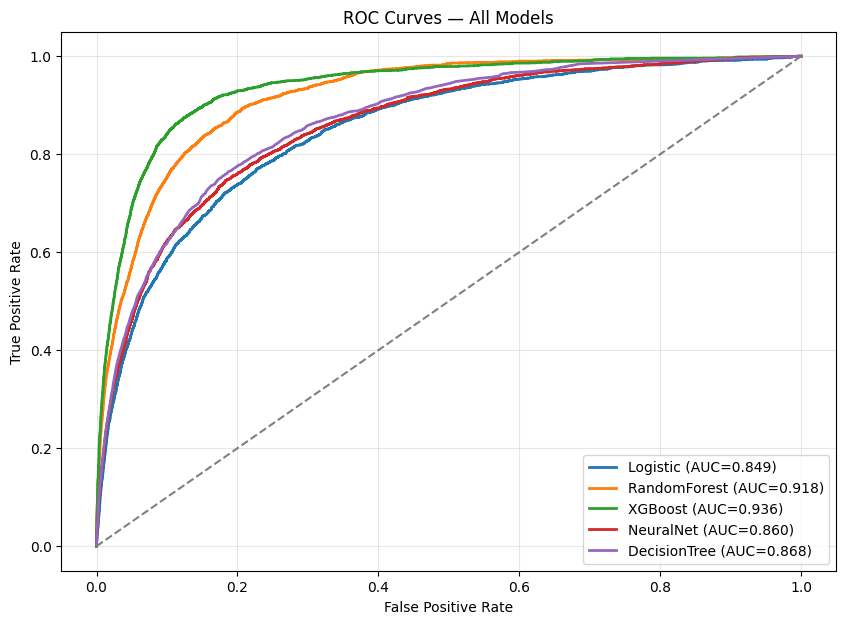

In [0]:
# ============================================================
# 2. SIDE-BY-SIDE ROC CURVES FOR ALL MODELS
# ============================================================

plt.figure(figsize=(10, 7))

for name, (_, test_p) in models.items():
    fpr, tpr, _ = roc_curve(y_test, test_p)
    auc_score = roc_auc_score(y_test, test_p)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curves — All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


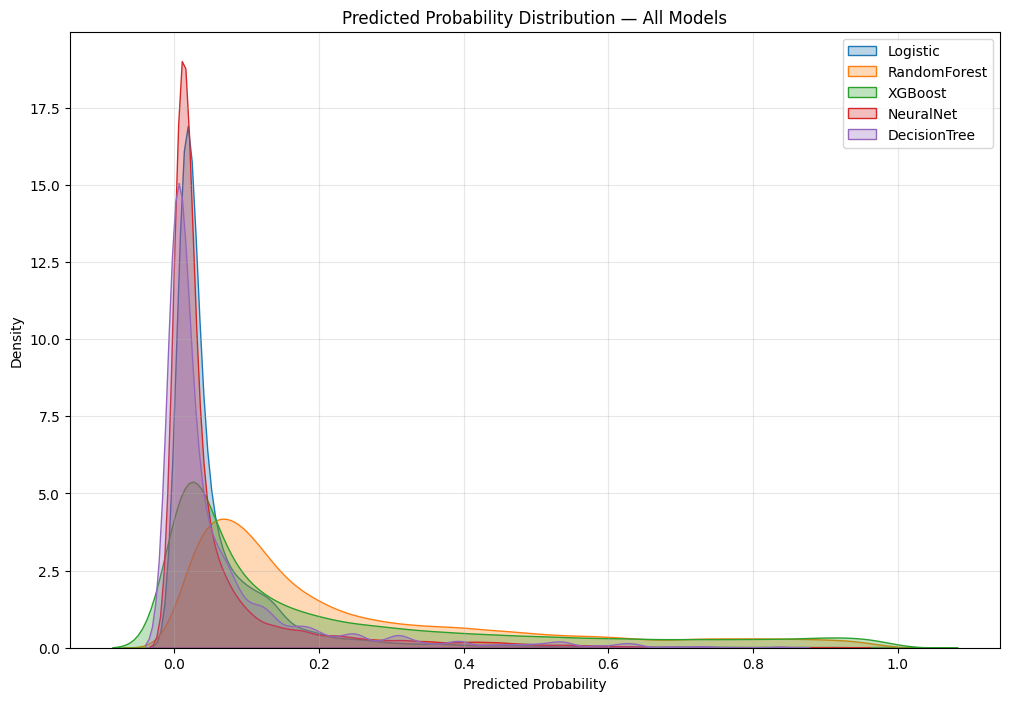

In [0]:
# ============================================================
# 3. PREDICTED PROBABILITY DISTRIBUTIONS SIDE-BY-SIDE
# ============================================================

plt.figure(figsize=(12, 8))

for name, (_, test_p) in models.items():
    sns.kdeplot(test_p, fill=True, alpha=0.3, label=name)

plt.title("Predicted Probability Distribution — All Models")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


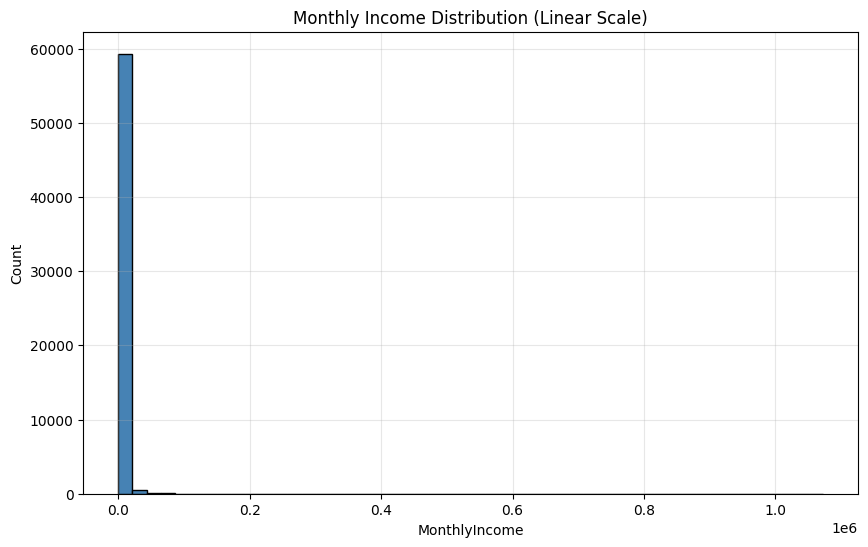

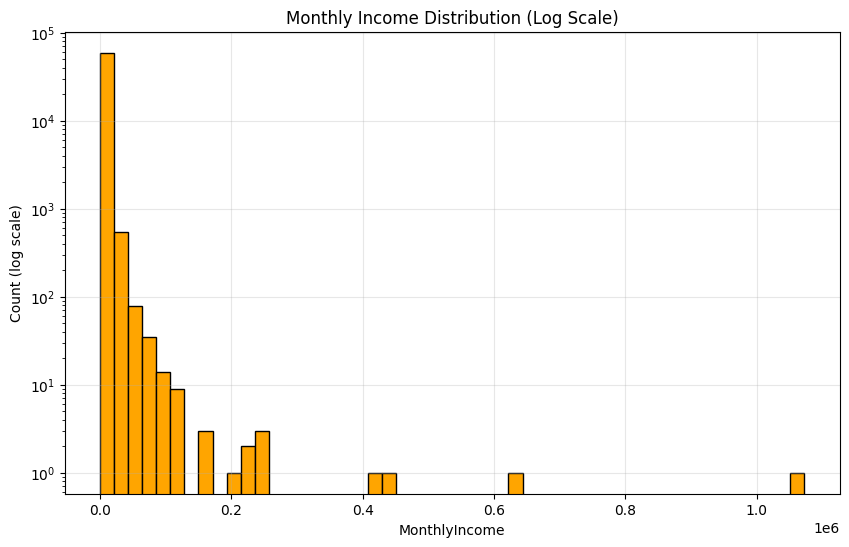

Income Statistics:
 count    6.000000e+04
mean     6.346994e+03
std      7.944244e+03
min      0.000000e+00
25%      3.943000e+03
50%      5.400000e+03
75%      7.400000e+03
max      1.072500e+06
Name: income, dtype: float64
<50k: 59881 rows
50–100k: 95 rows
>100k: 24 rows
33% Quantile: 4666.0
66% Quantile: 6014.340000000004
Low Income: 19806 rows
Medium Income: 19794 rows
High Income: 20400 rows


In [0]:
import matplotlib.pyplot as plt

test_df = X_test.copy()
test_df["y_true"] = y_test.values
test_df["income"] = test_df["MonthlyIncome"]

# attach predictions (aligned row-by-row)
test_df["logreg_p"] = logreg_pred_proba
test_df["rf_p"] = rf_pred_proba
test_df["xgb_p"] = xgb_pred_proba
test_df["nn_p"] = nn_pred_proba
test_df["dt_p"] = dt_pred_proba
plt.figure(figsize=(10,6))
plt.hist(test_df["income"], bins=50, color='steelblue', edgecolor='black')
plt.title("Monthly Income Distribution (Linear Scale)")
plt.xlabel("MonthlyIncome")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
plt.hist(test_df["income"], bins=50, color='orange', edgecolor='black')
plt.yscale('log')
plt.title("Monthly Income Distribution (Log Scale)")
plt.xlabel("MonthlyIncome")
plt.ylabel("Count (log scale)")
plt.grid(alpha=0.3)
plt.show()
print("Income Statistics:\n", test_df["income"].describe())
buckets = {
    "<50k": test_df[test_df.income < 50000],
    "50–100k": test_df[(test_df.income >= 50000) & (test_df.income <= 100000)],
    ">100k": test_df[test_df.income > 100000]
}

for name, seg in buckets.items():
    print(f"{name}: {len(seg)} rows")
# ==========================================
# Quantile-based segmentation (balanced)
# ==========================================

q1 = test_df["income"].quantile(0.33)
q2 = test_df["income"].quantile(0.66)

print("33% Quantile:", q1)
print("66% Quantile:", q2)

segments = {
    "Low Income":    test_df[test_df.income <= q1],
    "Medium Income": test_df[(test_df.income > q1) & (test_df.income <= q2)],
    "High Income":   test_df[test_df.income > q2]
}

for name, seg in segments.items():
    print(f"{name}: {len(seg)} rows")


In [0]:
# ============================================================
# PREPARE test_df WITH ALL MODEL PREDICTIONS
# ============================================================

test_df = X_test.copy()
test_df["y_true"] = y_test.values
test_df["income"] = test_df["MonthlyIncome"]

# attach predictions (aligned row-by-row)
test_df["logreg_p"] = logreg_pred_proba
test_df["rf_p"] = rf_pred_proba
test_df["xgb_p"] = xgb_pred_proba
test_df["nn_p"] = nn_pred_proba
test_df["dt_p"] = dt_pred_proba


# ============================================================
# QUANTILE-BASED SEGMENTATION (balanced)
# ============================================================

q1 = test_df["income"].quantile(0.33)
q2 = test_df["income"].quantile(0.66)

print("33% Quantile:", q1)
print("66% Quantile:", q2)

segments = {
    "Low Income":    test_df[test_df.income <= q1],
    "Medium Income": test_df[(test_df.income > q1) & (test_df.income <= q2)],
    "High Income":   test_df[test_df.income > q2]
}

for name, seg in segments.items():
    print(f"{name}: {len(seg)} rows")


# ============================================================
# EVALUATE MODELS WITHIN EACH SEGMENT
# ============================================================

from sklearn.metrics import roc_auc_score, f1_score

segment_results = []

model_columns = {
    "Logistic":      "logreg_p",
    "RandomForest":  "rf_p",
    "XGBoost":       "xgb_p",
    "NeuralNet":     "nn_p",
    "DecisionTree":  "dt_p"
}

for seg_name, seg in segments.items():
    yt = seg["y_true"]

    for model_name, col in model_columns.items():
        p = seg[col]

        auc = roc_auc_score(yt, p)
        f1  = f1_score(yt, (p > 0.5).astype(int))

        segment_results.append([seg_name, model_name, auc, f1])

segment_df = pd.DataFrame(segment_results, columns=["Segment","Model","AUC","F1"])
print("\n================= SEGMENT RESULTS =================")
print(segment_df)


# ============================================================
# BEST MODEL PER SEGMENT (like professor table)
# ============================================================

best_models = (
    segment_df.sort_values(["Segment","AUC"], ascending=[True, False])
              .groupby("Segment")
              .head(1)
)

print("\n================= BEST MODEL PER SEGMENT =================")
print(best_models)


33% Quantile: 4666.0
66% Quantile: 6014.340000000004
Low Income: 19806 rows
Medium Income: 19794 rows
High Income: 20400 rows

================= SEGMENT RESULTS =================
          Segment         Model       AUC        F1
0      Low Income      Logistic  0.835983  0.219490
1      Low Income  RandomForest  0.901811  0.475581
2      Low Income       XGBoost  0.924486  0.515572
3      Low Income     NeuralNet  0.846889  0.216393
4      Low Income  DecisionTree  0.854383  0.307184
5   Medium Income      Logistic  0.871749  0.229291
6   Medium Income  RandomForest  0.927751  0.465267
7   Medium Income       XGBoost  0.940660  0.486044
8   Medium Income     NeuralNet  0.876719  0.208683
9   Medium Income  DecisionTree  0.884746  0.344214
10    High Income      Logistic  0.827978  0.225879
11    High Income  RandomForest  0.922583  0.502007
12    High Income       XGBoost  0.939735  0.571815
13    High Income     NeuralNet  0.844083  0.172555
14    High Income  DecisionTree  0.855176

In [0]:
# ============================================================
# 6. FINAL COMBINED REPORT (two tables side-by-side)
# ============================================================

print("\n==================== MODEL STABILITY SUMMARY ====================")
print(stability_df.to_string(index=False))

print("\n==================== SEGMENT-LEVEL BEST MODELS ===================")
print(best_models.to_string(index=False))

# Optional: combine as a dict for saving
final_report = {
    "model_stability_table": stability_df,
    "segment_best_models_table": best_models
}

joblib.dump(final_report, "final_report_summary.joblib")
print("\nSaved: final_report_summary.joblib")



==================== MODEL STABILITY SUMMARY ====================
       Model  Train AUC  Test AUC      Gap   Interpretation
    Logistic   0.855394  0.849314 0.006080      Very stable
RandomForest   0.959765  0.918317 0.041449 Some overfitting
     XGBoost   0.982132  0.936296 0.045836 Some overfitting
   NeuralNet   0.868854  0.859587 0.009267      Very stable
DecisionTree   0.895304  0.867756 0.027548 Some overfitting

==================== SEGMENT-LEVEL BEST MODELS ===================
      Segment   Model      AUC       F1
  High Income XGBoost 0.939735 0.571815
   Low Income XGBoost 0.924486 0.515572
Medium Income XGBoost 0.940660 0.486044

Saved: final_report_summary.joblib


In [0]:
end_time = time.time()
end_dt = dt.datetime.now()

elapsed_sec = end_time - start_time
elapsed_min = elapsed_sec / 60

print("Run finished at:", end_dt.strftime("%Y-%m-%d %H:%M:%S"))
print(f"Wall-clock time: {elapsed_sec:.1f} seconds ({elapsed_min:.2f} minutes)")


Run finished at: 2025-12-05 23:42:15
Wall-clock time: 991.0 seconds (16.52 minutes)
